# Bitcoin Volatility Prediction

## Importing Libraries

In [1]:
#!pip install -r requirements.txt

#### 파이썬 3.11.4 ver로 작성하였습니다.

In [2]:
import sys
sys.version

'3.11.4 (main, Jul  5 2023, 09:00:44) [Clang 14.0.6 ]'

In [3]:
import dask
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split

import BayesianOptimization
from bayes_opt import BayesianOptimization

import pmdarima as pm #auto_arima
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima
import statsmodels.api as sm

# Baseline model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit #Timeseires Split

import os
import warnings #경고 무시

In [4]:
# Print version
print("dask version:", dask.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)  
print("pmdarima version:", pm.__version__)
print("statsmodels version:", sm.__version__)
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)

dask version: 2023.6.0
pandas version: 1.5.3
numpy version: 1.24.3
scikit-learn version: 1.3.0
pmdarima version: 2.0.4
statsmodels version: 0.14.0
matplotlib version: 3.7.1
seaborn version: 0.12.2


In [5]:
## 기본 설정 값

# fig
figsize=(15,5)

# 결과창 출력의 최대 행 및 열 수 설정
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# 경고 무시 설정
# warnings.filterwarnings('ignore')
# KPSS에서 경고가 하나 떴는데 큰 영향을 미치지 않는다고 하여 작성
# 경고 무시 설정은 다른 코드들 작성할 때 주석 처리해 가며 확인 필요

- 리샘플링 함수

In [6]:
def convert_tick_to_ohlcv(data):
    """
    Converts given Binance tick data into 1-hour interval OHLCV (Open, High, Low, Close, Volume) data.
    :param data: DataFrame with Tick data
    :return: DataFrame with the Open, High, Low, Close, Volume values
    """

    data['time'] = pd.to_datetime(data['time'], unit='ms')
    ohlcv = data.resample('1H', on='time').agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'quote_qty': 'std', # 추가
        'is_buyer_maker': 'sum'}) #추가
        

    ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'Volume','quote_qty','is_buyer_maker']
    return ohlcv

def calculate_volatility(data, window=20):
    """
    Calculate the rolling volatility using the standard deviation of returns.
    :param data: DataFrame with OHLCV data
    :param window: The number of periods to use for calculating the standard deviation
    :return: DataFrame with the volatility values
    """

    # Calculate daily returns
    data['returns'] = data['Close'].pct_change()

    # Calculate the rolling standard deviation of returns
    data['volatility'] = data['returns'].rolling(window=window).std()

    return data

### Loading Data

- 제공된 원본 데이터 파일 리스트(경로 수정 필요)

In [7]:
file_list = [
    '../data/BTCUSDT-trades-2023-01.csv',
    '../data/BTCUSDT-trades-2023-02.csv',
    '../data/BTCUSDT-trades-2023-03.csv',
    '../data/BTCUSDT-trades-2023-04.csv',
    '../data/BTCUSDT-trades-2023-05.csv',
    '../data/BTCUSDT-trades-2023-06.csv',
    '../data/BTCUSDT-trades-2023-07.csv',
    '../data/BTCUSDT-trades-2023-08.csv',
    '../data/BTCUSDT-trades-2023-09.csv',
    '../data/BTCUSDT-trades-2023-10.csv',
    '../data/BTCUSDT-trades-2023-11.csv',
    '../data/BTCUSDT-trades-2023-12.csv',
    '../data/BTCUSDT-trades-2024-01-01.csv',
    '../data/BTCUSDT-trades-2024-01-02.csv',
    '../data/BTCUSDT-trades-2024-01-03.csv',
    '../data/BTCUSDT-trades-2024-01-04.csv',
    '../data/BTCUSDT-trades-2024-01-05.csv',
    '../data/BTCUSDT-trades-2024-01-06.csv',
    '../data/BTCUSDT-trades-2024-01-07.csv',
    '../data/BTCUSDT-trades-2024-01-08.csv',
    '../data/BTCUSDT-trades-2024-01-09.csv',
    '../data/BTCUSDT-trades-2024-01-10.csv',
    '../data/BTCUSDT-trades-2024-01-11.csv',
    '../data/BTCUSDT-trades-2024-01-12.csv',
    '../data/BTCUSDT-trades-2024-01-13.csv',
    '../data/BTCUSDT-trades-2024-01-14.csv',
    '../data/BTCUSDT-trades-2024-01-15.csv',
    '../data/BTCUSDT-trades-2024-01-16.csv',
    '../data/BTCUSDT-trades-2024-01-17.csv',
    '../data/BTCUSDT-trades-2024-01-18.csv',
    '../data/BTCUSDT-trades-2024-01-19.csv',
    '../data/BTCUSDT-trades-2024-01-20.csv',
    '../data/BTCUSDT-trades-2024-01-21.csv',
    '../data/BTCUSDT-trades-2024-01-22.csv',
    '../data/BTCUSDT-trades-2024-01-23.csv',
    '../data/BTCUSDT-trades-2024-01-24.csv',
    '../data/BTCUSDT-trades-2024-01-25.csv',
    '../data/BTCUSDT-trades-2024-01-26.csv',
    '../data/BTCUSDT-trades-2024-01-27.csv'   

]

- 대용량 데이터 처리 > dask 라이브러리 이용
    - 처리 순서 : 개별 파일 dask.read_csv > pandas dataframe으로 변경 > 변환함수 적용 > append > 전체 데이터 concat

In [8]:
# 데이터를 담을 빈 리스트 생성
combined_dfs = []

# 각 파일에 대해 처리
for file in file_list:
    print(f"Reading and processing file: {file}")
    
    # 파일을 Dask DataFrame으로 읽기
    dask_df = dd.read_csv(file, usecols=['price', 'qty', 'quote_qty', 'time', 'is_buyer_maker'], dtype={'price': float, 'qty': float, 'quote_qty': float, 'time': float})
    
    try:
        # 변환 함수 적용
        computed_df = dask_df.compute()
        # 예외 처리
        try:
            processed_df = convert_tick_to_ohlcv(computed_df)
            combined_dfs.append(processed_df)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    except Exception as e:
        print(f"Error reading file {file}: {e}")

# 모든 파일 처리가 끝나면 리스트에 있는 모든 DataFrame을 concat하여 하나의 DataFrame으로 만듦
combined_df = pd.concat(combined_dfs, ignore_index=False)


Reading and processing file: ../data/BTCUSDT-trades-2023-01.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-02.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-03.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-04.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-05.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-06.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-07.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-08.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-09.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-10.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-11.csv
Reading and processing file: ../data/BTCUSDT-trades-2023-12.csv
Reading and processing file: ../data/BTCUSDT-trades-2024-01-01.csv
Reading and processing file: ../data/BTCUSDT-trades-2024-01-02.csv
Reading and processing file: ../data/BTCUSDT-trades-2024-01-03.csv
Reading and processing file: ..

- 변동성 계산

In [9]:
volatility_data = calculate_volatility(combined_df)

In [10]:
df = volatility_data.copy()

In [11]:
#df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)
df.isnull().sum()
dfc = df.copy()

### Sloving Caution

In [12]:
# 경고 해결용(returns ARIMA) - 인덱스에 주파수 정보 추가

# 기존 데이터프레임의 인덱스를 활용하여 새로운 인덱스 생성
new_date_rng = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# 새로운 인덱스를 기존 데이터프레임의 인덱스로 설정
df = df.reindex(new_date_rng)

## 1. Preprocessing

### 1-1. Checking Missing Value

In [13]:
# 일단위 출력 함수

def Visualizing_returns_d(dfc, df, start_date, end_date, figsize=(15,5)):
    
    df_filtered = df.loc[start_date:end_date]
    dfc_filtered = dfc.loc[start_date:end_date]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    
    ax[0].plot(df_filtered.index, dfc_filtered)
    ax[0].set_ylabel('returns')
    ax[0].set_title(f'{start_date}-{end_date}')
    ax[0].set_xticks([])

    ax[1].plot(df_filtered.index, df_filtered)
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('returns')
    ax[1].set_title(f'{start_date}-{end_date}')
    
    ax[1].xaxis.set_major_locator(mdates.DayLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.show()

#### - price(Open, High, Low, Close, price), quote_qty

In [14]:
display(df[df['Open'].isnull()].index)

DatetimeIndex(['2023-01-23 21:00:00', '2023-01-23 22:00:00',
               '2023-01-23 23:00:00', '2023-01-24 21:00:00',
               '2023-01-24 22:00:00', '2023-01-24 23:00:00',
               '2023-01-25 16:00:00', '2023-01-25 17:00:00',
               '2023-01-25 18:00:00', '2023-01-25 19:00:00',
               '2023-01-25 20:00:00', '2023-01-25 21:00:00',
               '2023-01-25 22:00:00', '2023-01-25 23:00:00',
               '2023-01-26 22:00:00', '2023-01-26 23:00:00',
               '2023-03-14 23:00:00', '2023-03-15 22:00:00',
               '2023-03-15 23:00:00', '2023-11-21 03:00:00',
               '2023-11-21 04:00:00', '2023-11-21 05:00:00',
               '2023-11-21 06:00:00', '2023-11-21 07:00:00'],
              dtype='datetime64[ns]', freq=None)

#### - returns

In [15]:
df[df['returns'].isnull()].index # 매달 1일 1시간

DatetimeIndex(['2023-01-01'], dtype='datetime64[ns]', freq='H')

#### - volatility

In [16]:
df[df['volatility'].isnull()].index

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00'],
              dtype='datetime64[ns]', freq='H')

### 1-1-2. Interpolate MIssing Value - functions

In [17]:
# spline 보간
def spline_interpolate_column(df, column_name, order=3):
    df[column_name] = df[column_name].interpolate(method='spline', order=order)

In [18]:
# ARIMA 보간
def ARIMA_Interpolate(df, column_list):
    
    for column in column_list:
        df_column = df[column]  # 해당 컬럼 선택

        # 최적의 ARIMA 모델 선택
        autoarima_model = pm.auto_arima(df_column.dropna(), suppress_warnings=True)
        order = autoarima_model.order
        print(order)
        
        # 결측치 보간 전 ARIMA 모델 훈련
        model = sm.tsa.ARIMA(df_column.dropna(), order=order)  # p, d, q는 ARIMA 모델의 차수
        results = model.fit()

        # 보간할 결측치 선택
        missing_indices = df_column[df_column.isnull()].index

        # 결측치 보간
        for idx in missing_indices:
            # ARIMA 모델을 사용하여 결측치 예측
            predicted_value = results.get_forecast(steps=1).predicted_mean.iloc[0]  # 예측 결과의 첫 번째 값을 사용

            # 결측치 보간
            df_column[idx] = predicted_value

### 1-1-3. Interpolate Missing Value - Interpolate

#### - price(Open, High, Low, Close, price), quote_qty

In [19]:
columns_to_interpolate = ['Open', 'High', 'Low', 'Close']

for column in columns_to_interpolate:
    spline_interpolate_column(df, column, order=3)

In [20]:
columns_to_interpolate_volume = ['quote_qty']

for column in columns_to_interpolate_volume:
    spline_interpolate_column(df, column, order=3)

In [21]:
df.isna().sum()

Open               0
High               0
Low                0
Close              0
Volume             0
quote_qty          0
is_buyer_maker     0
returns            1
volatility        20
dtype: int64

#### - returns

In [22]:
returns_list=['returns']
ARIMA_Interpolate(df, returns_list)

(0, 0, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


#### - volatility

In [23]:
volatility_list=['volatility']
ARIMA_Interpolate(df, volatility_list)

/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


(1, 1, 0)


/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


In [24]:
df.isna().sum()

Open              0
High              0
Low               0
Close             0
Volume            0
quote_qty         0
is_buyer_maker    0
returns           0
volatility        0
dtype: int64

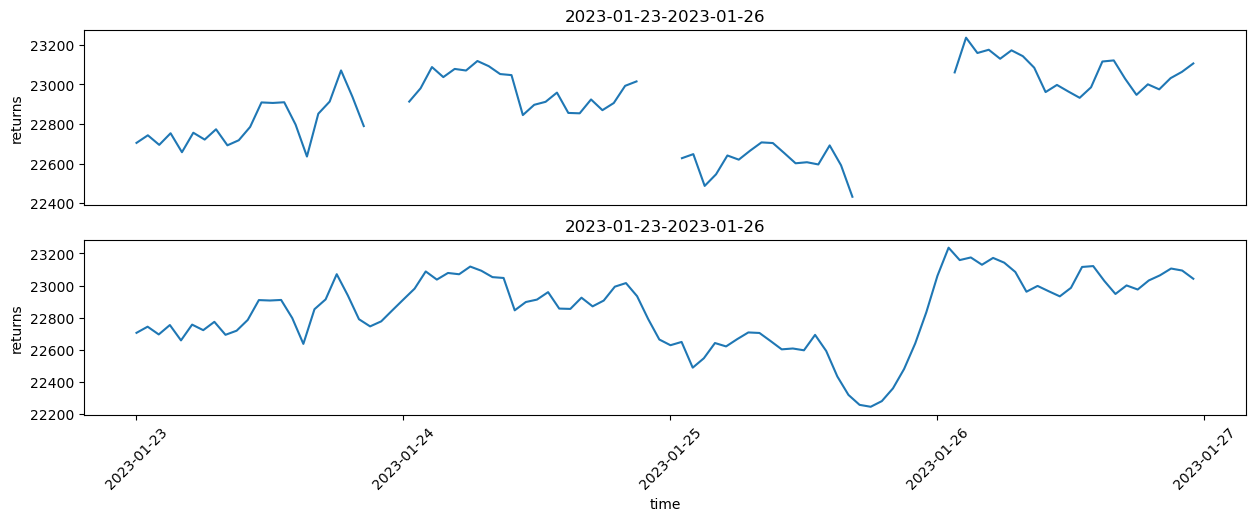

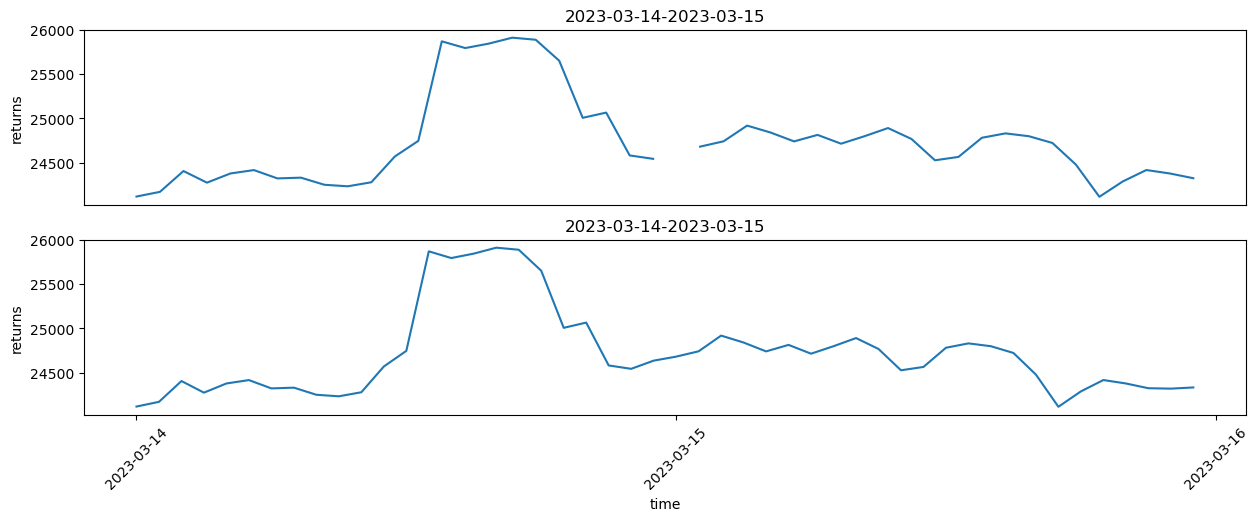

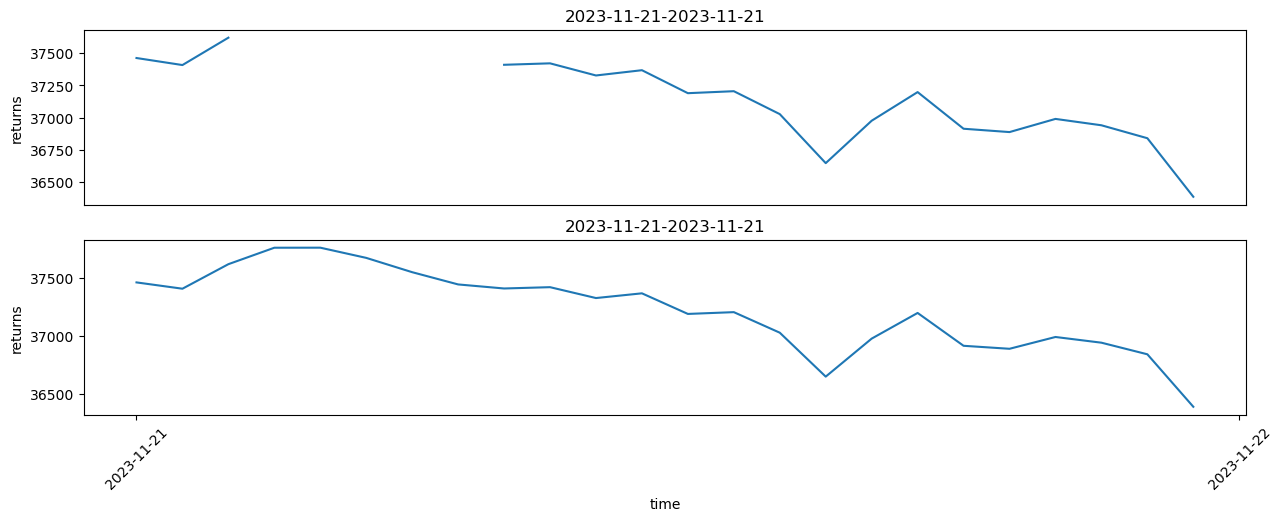

In [25]:
Visualizing_returns_d(dfc['Open'], df['Open'],'2023-01-23', '2023-01-26')
Visualizing_returns_d(dfc['Open'], df['Open'],'2023-03-14', '2023-03-15')
Visualizing_returns_d(dfc['Open'], df['Open'],'2023-11-21', '2023-11-21')

### 1-2. Technical Indicators

#### MACD Function (Moving Average Convergence Divergence)
Calculates the difference between short-term and long-term moving averages to indicate trends.
Quickly detects trends but may be sensitive to noise.
#### Stochastic Oscillator Function
An indicator that reflects the trend of price fluctuations in financial markets such as stocks.
Calculates the relative strength of the price based on the highest (High) and lowest (Low) prices over the last N days.
#### ATR Function (Average True Range)
An indicator that represents the average range of price movements.
Calculates volatility using True Range.
#### Bollinger Bands Function
An indicator that uses moving averages and standard deviation to assess the relative height of prices.
Forms upper and lower bands around the moving average, indicating deviations in stock prices.
#### ROC Function (Rate of Change)
Measures the relative price change over a certain period.
Analyzes the flow of stock prices by comparing the current price with the price a certain period ago.
#### RSI Function (Relative Strength Index)
Relative Strength Index indicating the relative strength of price movements over a specific period.
Generally, values above 70 indicate an uptrend, while values below 30 indicate a downtrend.
#### Ultimate Oscillator Function
A comprehensive indicator that combines relative strength for various periods.
Provides a richer analysis of the stock price trend.

###  1-2-1. Technical Indicators - functions

In [26]:
# MACD 함수
def MACD(data, short_window, long_window, signal_window):
    
    data[f'Short_MA_{short_window}'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data[f'Long_MA_{long_window}'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data[f'MACD_{short_window}{long_window}'] = data[f'Short_MA_{short_window}'] - data[f'Long_MA_{long_window}']
    data[f'Signal_Line_{signal_window}'] = data[f'MACD_{short_window}{long_window}'].ewm(span=signal_window, adjust=False).mean()
    data[f'MACD_Oscillator_{short_window}{long_window}'] = data[f'MACD_{short_window}{long_window}'] - data[f'Signal_Line_{signal_window}']
    
    data.drop([f'Short_MA_{short_window}', f'Long_MA_{long_window}'], axis=1, inplace=True)
    
    return data
    
    
# Stochastic Oscillator 함수
def cal_stoc_os(df, period, m):
    
    # 최근 N일간의 최고가(H)와 최저가(L)
    df[f'SO high_{period}{m}'] = df['High'].rolling(window=period).max()
    df[f'SO low_{period}{m}'] = df['Low'].rolling(window=period).min()
    
    # %K 계산
    df[f'SO %K_{period}{m}'] = (df['Close'] - df[f'SO low_{period}{m}']) / (df[f'SO high_{period}{m}'] - df[f'SO low_{period}{m}']) * 100
    
    # %D 계산
    df[f'SO %D_{period}{m}'] = df[f'SO %K_{period}{m}'].rolling(m).mean()
    
    return df
    
    
# ATR 함수
def calculate_atr(df, period):
    # True Range 계산
    df['high-low'] = df['High'] - df['Low']
    df['high-close'] = abs(df['High'] - df['Close'].shift())
    df['low-close'] = abs(df['Low'] - df['Close'].shift())
    
    df['true_range'] = df[['high-low', 'high-close', 'low-close']].max(axis=1)
    
    # ATR 계산
    df[f'atr_{period}'] = df['true_range'].rolling(window=period, min_periods=1).mean()
    
    # 임시 열 삭제
    df.drop(['high-low', 'high-close', 'low-close', 'true_range'], axis=1, inplace=True)
    
    return df


# Bollinger_band 함수
def bollinger_bands(df, window, num_std_dev):
    
    # 이동평균 계산
    df['rolling_mean'] = df['Close'].rolling(window=window).mean()

    # 표준편차 계산
    df['rolling_std'] = df['Close'].rolling(window=window).std()

    # 볼린저 밴드 상단 및 하단 계산
    df[f'upper_band_{window}'] = df['rolling_mean'] + (num_std_dev * df['rolling_std'])
    df[f'lower_band_{window}'] = df['rolling_mean'] - (num_std_dev * df['rolling_std'])

    # 필요없는 컬럼 삭제
    df.drop(['rolling_mean', 'rolling_std'], axis=1, inplace=True)

    return df


# ROC 계산 함수
def calculate_roc(df, close_column, timeperiod):
    prev_close = df[close_column].shift(timeperiod)
    df[f'roc_{timeperiod}'] = ((df[close_column] - prev_close) / prev_close) * 100
    
    return df


# RSI 계산 함수
def calculate_rsi(df, close_column, timeperiod):
    delta = df[close_column].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=timeperiod, min_periods=1).mean()
    avg_loss = loss.rolling(window=timeperiod, min_periods=1).mean()

    rs = avg_gain / avg_loss
    df[f'rsi_{timeperiod}'] = 100 - (100 / (1 + rs))
    
    return df


# Ultimate Oscillator 함수
def calculate_uo(df, period1, period2, period3):
    # True Range 계산
    df['true_range'] = df['High'].combine(df['Close'].shift(1), max) - df['Low'].combine(df['Close'].shift(1), min)
    
    # Average True Range (ATR) 계산
    df['avg_true_range1'] = df['true_range'].rolling(window=period1, min_periods=1).mean()
    df['avg_true_range2'] = df['true_range'].rolling(window=period2, min_periods=1).mean()
    df['avg_true_range3'] = df['true_range'].rolling(window=period3, min_periods=1).mean()

    # Buying Pressure 계산
    df['buying_pressure'] = df['Close'] - df[['Open', 'Close']].min(axis=1)

    # True Buying Pressure (TBP) 계산
    df['true_buying_pressure1'] = df['buying_pressure'].rolling(window=period1, min_periods=1).sum()
    df['true_buying_pressure2'] = df['buying_pressure'].rolling(window=period2, min_periods=1).sum()
    df['true_buying_pressure3'] = df['buying_pressure'].rolling(window=period3, min_periods=1).sum()

    # UO 계산
    df[f'UO_{period1}{period2}{period3}'] = (
        100
        * (4 * df['true_buying_pressure1'] / df['avg_true_range1'])
        + 2 * (4 * df['true_buying_pressure2'] / df['avg_true_range2'])
        + (df['true_buying_pressure3'] / df['avg_true_range3'])
    ) / (4 + 2 + 1)

    # 필요 없는 열 제거
    df = df.drop(['true_range', 'avg_true_range1', 'avg_true_range2', 'avg_true_range3',
                  'buying_pressure', 'true_buying_pressure1', 'true_buying_pressure2', 'true_buying_pressure3'], axis=1)

    return df

### 1-2-2. Technical Indicators - Generate

In [27]:
# df와 df_idc의 구분을 위한 copy
df_copy=df.copy()

In [28]:
df_idc = MACD(df_copy, 6, 13, 4) # 단기추세 감지 but 노이즈에 민감할 가능성 있음
df_idc = MACD(df_idc, 12, 26, 9) # 일반적인 window 계수 but 변동성이 큰 시장에선 느리게 반응할 수 있음
df_idc = MACD(df_idc, 5, 26, 9) 

df_idc = calculate_atr(df_idc, period=14) 
df_idc = calculate_atr(df_idc, period=20)

df_idc = cal_stoc_os(df_idc, period=20, m=2)
df_idc = cal_stoc_os(df_idc, period=14, m=2)
df_idc = cal_stoc_os(df_idc, period=30, m=2)

df_idc = cal_stoc_os(df_idc, period=20, m=3)
df_idc = cal_stoc_os(df_idc, period=14, m=3)
df_idc = cal_stoc_os(df_idc, period=30, m=3)

df_idc = cal_stoc_os(df_idc, period=20, m=5)
df_idc = cal_stoc_os(df_idc, period=14, m=5)
df_idc = cal_stoc_os(df_idc, period=30, m=5)

df_idc = cal_stoc_os(df_idc, period=20, m=10)
df_idc = cal_stoc_os(df_idc, period=14, m=10)
df_idc = cal_stoc_os(df_idc, period=30, m=10)

df_idc = bollinger_bands(df_idc, window=20, num_std_dev=1.5)
df_idc = bollinger_bands(df_idc, window=15, num_std_dev=1.5)
df_idc = bollinger_bands(df_idc, window=10, num_std_dev=1.5)
df_idc = bollinger_bands(df_idc, window=20, num_std_dev=2)
df_idc = bollinger_bands(df_idc, window=15, num_std_dev=2)
df_idc = bollinger_bands(df_idc, window=10, num_std_dev=2)

df_idc = calculate_roc(df_idc, close_column='Close', timeperiod=1)
df_idc = calculate_roc(df_idc, close_column='Close', timeperiod=2)

df_idc = calculate_rsi(df_idc, close_column='Close', timeperiod=7)
df_idc = calculate_rsi(df_idc, close_column='Close', timeperiod=9)
df_idc = calculate_rsi(df_idc, close_column='Close', timeperiod=14)

df_idc_all = calculate_uo(df_idc, 7, 10, 14)
df_idc_all = calculate_uo(df_idc, 7, 9, 11)
df_idc_all = calculate_uo(df_idc, 7, 10, 12)

In [29]:
df_idc_all.shape

(9408, 81)

### 1-3. Checking Missing Value

In [30]:
df_idc_all.isna().sum()

Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
quote_qty                0
is_buyer_maker           0
returns                  0
volatility               0
MACD_613                 0
Signal_Line_4            0
MACD_Oscillator_613      0
MACD_1226                0
Signal_Line_9            0
MACD_Oscillator_1226     0
MACD_526                 0
MACD_Oscillator_526      0
atr_14                   0
atr_20                   0
SO high_202             19
SO low_202              19
SO %K_202               19
SO %D_202               20
SO high_142             13
SO low_142              13
SO %K_142               13
SO %D_142               14
SO high_302             29
SO low_302              29
SO %K_302               29
SO %D_302               30
SO high_203             19
SO low_203              19
SO %K_203               19
SO %D_203               21
SO high_143             13
SO low_143              13
S

#### - SO

In [31]:
SO_list = ['SO high_202', 'SO low_202', 'SO %K_202', 'SO %D_202',
       'SO high_142', 'SO low_142', 'SO %K_142', 'SO %D_142', 'SO high_302',
       'SO low_302', 'SO %K_302', 'SO %D_302', 'SO high_203', 'SO low_203',
       'SO %K_203', 'SO %D_203', 'SO high_143', 'SO low_143', 'SO %K_143',
       'SO %D_143', 'SO high_303', 'SO low_303', 'SO %K_303', 'SO %D_303',
       'SO high_205', 'SO low_205', 'SO %K_205', 'SO %D_205', 'SO high_145',
       'SO low_145', 'SO %K_145', 'SO %D_145', 'SO high_305', 'SO low_305',
       'SO %K_305', 'SO %D_305', 'SO high_2010', 'SO low_2010', 'SO %K_2010',
       'SO %D_2010', 'SO high_1410', 'SO low_1410', 'SO %K_1410', 'SO %D_1410',
       'SO high_3010', 'SO low_3010', 'SO %K_3010', 'SO %D_3010']

ARIMA_Interpolate(df_idc_all, SO_list)

(1, 1, 3)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(5, 0, 0)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 1, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 0, 0)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(5, 0, 0)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(3, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(5, 0, 0)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 3)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(5, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 1, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 0, 0)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(5, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(3, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(5, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 3)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(5, 0, 0)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 1, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 0, 0)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(5, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(3, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(5, 0, 0)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 3)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 0, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 1, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 0, 0)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(4, 0, 3)


/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(3, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(1, 1, 2)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 0, 1)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(3, 0, 3)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


#### - BB

In [32]:
BB_list = ['upper_band_20', 'lower_band_20', 'upper_band_15','lower_band_15','upper_band_10','lower_band_10']  

ARIMA_Interpolate(df_idc_all, BB_list)

(3, 1, 4)


/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(4, 1, 3)


/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(3, 1, 5)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(2, 1, 3)


/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(3, 1, 5)


/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


(4, 1, 5)


/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/nz/vk3v33x95bs4kf3ymy0z0my00000gn/T/ipykernel_30168/3144430565.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_column[idx] = predicted_value


#### - roc, rsi

In [33]:
columns_to_bfill = ['roc_1', 'roc_2', 'rsi_7', 'rsi_9', 'rsi_14']

for column in columns_to_bfill:
    df_idc_all[column] = df_idc_all[column].bfill()

In [34]:
df_idc_all.isna().sum()

Open                    0
High                    0
Low                     0
Close                   0
Volume                  0
quote_qty               0
is_buyer_maker          0
returns                 0
volatility              0
MACD_613                0
Signal_Line_4           0
MACD_Oscillator_613     0
MACD_1226               0
Signal_Line_9           0
MACD_Oscillator_1226    0
MACD_526                0
MACD_Oscillator_526     0
atr_14                  0
atr_20                  0
SO high_202             0
SO low_202              0
SO %K_202               0
SO %D_202               0
SO high_142             0
SO low_142              0
SO %K_142               0
SO %D_142               0
SO high_302             0
SO low_302              0
SO %K_302               0
SO %D_302               0
SO high_203             0
SO low_203              0
SO %K_203               0
SO %D_203               0
SO high_143             0
SO low_143              0
SO %K_143               0
SO %D_143   

In [35]:
df_idc_all.head()

,Open,High,Low,Close,Volume,quote_qty,is_buyer_maker,returns,volatility,MACD_613,Signal_Line_4,MACD_Oscillator_613,MACD_1226,Signal_Line_9,MACD_Oscillator_1226,MACD_526,MACD_Oscillator_526,atr_14,atr_20,SO high_202,SO low_202,SO %K_202,SO %D_202,SO high_142,SO low_142,SO %K_142,SO %D_142,SO high_302,SO low_302,SO %K_302,SO %D_302,SO high_203,SO low_203,SO %K_203,SO %D_203,SO high_143,SO low_143,SO %K_143,SO %D_143,SO high_303,SO low_303,SO %K_303,SO %D_303,SO high_205,SO low_205,SO %K_205,SO %D_205,SO high_145,SO low_145,SO %K_145,SO %D_145,SO high_305,SO low_305,SO %K_305,SO %D_305,SO high_2010,SO low_2010,SO %K_2010,SO %D_2010,SO high_1410,SO low_1410,SO %K_1410,SO %D_1410,SO high_3010,SO low_3010,SO %K_3010,SO %D_3010,upper_band_20,lower_band_20,upper_band_15,lower_band_15,upper_band_10,lower_band_10,roc_1,roc_2,rsi_7,rsi_9,rsi_14,UO_71014,UO_7911,UO_71012
2023-01-01 00:00:00,16537.5,16540.9,16504.0,16527.0,5381.399,7264.129209,16494,0.000138,0.002201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.900,36.900,42190.943432,41361.354455,84.709818,86.669582,42196.353535,41684.151335,78.576192,82.587995,42239.620585,41380.319044,81.510047,82.825469,42190.943432,41361.354455,84.709818,88.586779,42196.353535,41684.151335,78.576192,85.249226,42239.620585,41380.319044,81.510047,84.766218,42190.943432,41361.354455,84.709818,93.252345,42196.353535,41684.151335,78.576192,89.571255,42239.620585,41380.319044,81.510047,85.094916,42190.943432,41361.354455,84.709818,79.153116,42196.353535,41684.151335,78.576192,86.038363,42239.620585,41380.319044,81.510047,77.751956,42189.870974,41457.938516,42210.006458,41562.774542,42286.896445,41602.459445,0.141586,0.093181,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000
2023-01-01 01:00:00,16527.1,16554.3,16524.1,16550.4,3210.826,6819.889969,8705,0.001416,0.002201,3.342857,1.337143,2.005714,1.866667,1.213333,1.493333,6.066667,4.853333,33.550,33.550,42190.943432,41361.354455,84.709818,86.669582,42196.353535,41684.151335,78.576192,82.587995,42239.620585,41380.319044,81.510047,82.825469,42190.943432,41361.354455,84.709818,88.586779,42196.353535,41684.151335,78.576192,85.249226,42239.620585,41380.319044,81.510047,84.766218,42190.943432,41361.354455,84.709818,93.252345,42196.353535,41684.151335,78.576192,89.571255,42239.620585,41380.319044,81.510047,85.094916,42190.943432,41361.354455,84.709818,79.153116,42196.353535,41684.151335,78.576192,86.038363,42239.620585,41380.319044,81.510047,77.751956,42189.870974,41457.938516,42210.006458,41562.774542,42286.896445,41602.459445,0.141586,0.093181,100.000000,100.000000,100.000000,40.577816,40.577816,40.577816
2023-01-01 02:00:00,16550.5,16557.1,16534.8,16542.4,2399.668,6030.420093,8468,-0.000483,0.002201,4.110204,2.446367,1.663837,2.669706,2.488198,1.837098,7.587654,5.099457,29.800,29.800,42190.943432,41361.354455,84.709818,86.669582,42196.353535,41684.151335,78.576192,82.587995,42239.620585,41380.319044,81.510047,82.825469,42190.943432,41361.354455,84.709818,88.586779,42196.353535,41684.151335,78.576192,85.249226,42239.620585,41380.319044,81.510047,84.766218,42190.943432,41361.354455,84.709818,93.252345,42196.353535,41684.151335,78.576192,89.571255,42239.620585,41380.319044,81.510047,85.094916,42190.943432,41361.354455,84.709818,79.153116,42196.353535,41684.151335,78.576192,86.038363,42239.620585,41380.319044,81.510047,77.751956,42189.870974,41457.938516,42210.006458,41562.774542,42286.896445,41602.459445,-0.048337,0.093181,74.522293,74.522293,74.522293,45.684084,45.684084,45.684084
2023-01-01 03:00:00,16542.5,16542.5,16515.0,16529.3,3214.480,7003.352799,10007,-0.000792,0.002201,2.540816,2.484147,0.056669,2.223429,2.979136,1.112657,4.942890,1.963754,29.225,29.225,42190.943432,41361.354455,84.709818,86.669582,42196.353535,41684.151335,78.576192,82.587995,42239.620585,41380.319044,81.510047,82.825469,42190.943432,41361.354455,84.709818,88.586779,42196.353535,41684.151335,78.576192,85.249226,42239.620585,41380.319044,81.510047,84

In [36]:
df_idc_all.tail()

,Open,High,Low,Close,Volume,quote_qty,is_buyer_maker,returns,volatility,MACD_613,Signal_Line_4,MACD_Oscillator_613,MACD_1226,Signal_Line_9,MACD_Oscillator_1226,MACD_526,MACD_Oscillator_526,atr_14,atr_20,SO high_202,SO low_202,SO %K_202,SO %D_202,SO high_142,SO low_142,SO %K_142,SO %D_142,SO high_302,SO low_302,SO %K_302,SO %D_302,SO high_203,SO low_203,SO %K_203,SO %D_203,SO high_143,SO low_143,SO %K_143,SO %D_143,SO high_303,SO low_303,SO %K_303,SO %D_303,SO high_205,SO low_205,SO %K_205,SO %D_205,SO high_145,SO low_145,SO %K_145,SO %D_145,SO high_305,SO low_305,SO %K_305,SO %D_305,SO high_2010,SO low_2010,SO %K_2010,SO %D_2010,SO high_1410,SO low_1410,SO %K_1410,SO %D_1410,SO high_3010,SO low_3010,SO %K_3010,SO %D_3010,upper_band_20,lower_band_20,upper_band_15,lower_band_15,upper_band_10,lower_band_10,roc_1,roc_2,rsi_7,rsi_9,rsi_14,UO_71014,UO_7911,UO_71012
2024-01-27 19:00:00,41785.0,41977.0,41775.1,41896.4,7765.565,18797.517191,38285,0.002668,0.002019,40.403682,30.996484,9.407198,146.529443,210.556287,-34.805681,189.875650,-20.680636,152.521429,145.215,41977.0,41360.1,86.934673,78.656203,41977.0,41360.1,86.934673,84.282095,42239.3,41002.1,72.284190,69.303734,41977.0,41360.1,86.934673,73.936576,41977.0,41360.1,86.934673,82.405076,42239.3,41002.1,72.284190,67.927335,41977.0,41360.1,86.934673,67.082359,41977.0,41360.1,86.934673,82.564744,42239.3,41002.1,72.284190,70.994755,41977.0,41360.1,86.934673,55.794468,41977.0,41360.1,86.934673,72.340528,42239.3,41002.1,72.284190,74.633851,41926.282235,41574.097765,41919.616474,41543.050193,41873.682804,41669.537196,0.266843,0.304050,86.169284,82.137285,58.884892,98.254035,97.631804,98.239248
2024-01-27 20:00:00,41896.5,42070.0,41896.4,42049.6,5408.243,16324.490996,35317,0.003657,0.002154,69.666208,46.464374,23.201834,157.992808,215.865915,-18.673852,237.104426,21.238511,155.557143,145.490,42070.0,41360.1,97.126356,92.030515,42070.0,41360.1,97.126356,92.030515,42239.3,41200.0,81.747330,77.015760,42070.0,41360.1,97.126356,84.812921,42070.0,41360.1,97.126356,88.563515,42239.3,41200.0,81.747330,73.451600,42070.0,41360.1,97.126356,76.559951,42070.0,41360.1,97.126356,85.359477,42239.3,41200.0,81.747330,71.387407,42070.0,41360.1,97.126356,60.392123,42070.0,41360.1,97.126356,76.524067,42239.3,41200.0,81.747330,74.961314,41985.315470,41542.744530,42001.586587,41501.266747,42002.304354,41604.515646,0.365664,0.633482,92.606285,88.448928,68.997644,157.603487,157.318754,157.646731
2024-01-27 21:00:00,42049.6,42165.6,42001.8,42137.8,5859.277,12457.410066,42103,0.002098,0.002189,97.338521,66.814032,30.524488,172.209487,229.346777,-3.565739,283.270228,53.923450,157.992857,145.190,42165.6,41360.1,96.548727,96.837542,42165.6,41360.1,96.548727,96.837542,42239.3,41360.1,88.455414,85.101372,42165.6,41360.1,96.548727,93.536586,42165.6,41360.1,96.548727,93.536586,42239.3,41360.1,88.455414,80.828978,42165.6,41360.1,96.548727,83.096962,42165.6,41360.1,96.548727,88.178062,42239.3,41360.1,88.455414,74.796950,42165.6,41360.1,96.548727,65.672564,42165.6,41360.1,96.548727,80.118429,42239.3,41360.1,88.455414,75.904040,42057.912127,41503.437873,42098.101003,41463.818997,42127.070891,41558.369109,0.209752,0.576183,93.761141,93.263918,71.553503,177.524225,177.319810,177.457956
2024-01-27 22:00:00,42137.8,42187.1,42057.6,42135.3,5271.863,16107.925688,39498,-0.000059,0.002191,109.950610,84.068663,25.881946,181.185979,244.302454,4.328603,304.125161,59.822707,144.371429,147.450,42187.1,41360.1,93.736397,95.142562,42187.1,41360.1,93.736397,95.142562,42239.3,41360.1,88.171065,88.313239,42187.1,41360.1,93.736397,95.803827,42187.1,41360.1,93.736397,95.803827,42239.3,41360.1,88.171065,86.124603,42187.1,41360.1,93.736397,88.944777,42187.1,41360.1,93.736397,91.195134,42239.3,41360.1,88.171065,79.396255,42187.1,41360.1,93.736397,70.832146,42187.1,41360.1,93.736397,83.353898,42239.3,41360.1,88.171065,76.878118,42115.612090,41477.047910,42171.859030,41448.220970,42208.820103,41557.559897,-0.005933,0.203807,92.353973,93.502343,93.779

In [37]:
#df_idc_all.to_csv('../data/final_dask.csv', index_label='time')

## 2. Feature Engineering

### 2-1. Feature combination optimization

In [38]:
# Test model

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rf_base(df, df_name, n_splits): 
    
    # Feature와 Target 나누기
    X = df.drop(columns=['volatility'])
    y = df['volatility']

    tscv = TimeSeriesSplit(n_splits)
    
    mape_list = []
    rmse_list = []

    # TimeSeriesSplit을 사용하여 데이터 분할
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        

        # RandomForestRegressor(베이지안옵티마이저 )
        rf_model = RandomForestRegressor(max_depth=None,
                                         max_features='sqrt',
                                         n_estimators=200,
                                         min_samples_split=5, 
                                         min_samples_leaf=2, 
                                         max_leaf_nodes=None,
                                         random_state=42)  # random_state 추가


        # 모델 학습
        rf_model.fit(X_train, y_train)

        # 예측
        y_pred = rf_model.predict(X_test)

        # 평가지표(MAPE, RMSE)
        test_mape = mean_absolute_percentage_error(y_test, y_pred)
        test_rmse = calculate_rmse(y_test, y_pred)
        
        # 결과 저장
        mape_list.append(test_mape)
        rmse_list.append(test_rmse)
        
        print(f'{df_name} : MAPE: {test_mape}, RMSE: {test_rmse}')
    
    # 평균 결과
    print(f'{df_name} : Average MAPE: {np.mean(mape_list)}, Average RMSE: {np.mean(rmse_list)}')

In [39]:
df_idc_all.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'quote_qty', 'is_buyer_maker',
       'returns', 'volatility', 'MACD_613', 'Signal_Line_4',
       'MACD_Oscillator_613', 'MACD_1226', 'Signal_Line_9',
       'MACD_Oscillator_1226', 'MACD_526', 'MACD_Oscillator_526', 'atr_14',
       'atr_20', 'SO high_202', 'SO low_202', 'SO %K_202', 'SO %D_202',
       'SO high_142', 'SO low_142', 'SO %K_142', 'SO %D_142', 'SO high_302',
       'SO low_302', 'SO %K_302', 'SO %D_302', 'SO high_203', 'SO low_203',
       'SO %K_203', 'SO %D_203', 'SO high_143', 'SO low_143', 'SO %K_143',
       'SO %D_143', 'SO high_303', 'SO low_303', 'SO %K_303', 'SO %D_303',
       'SO high_205', 'SO low_205', 'SO %K_205', 'SO %D_205', 'SO high_145',
       'SO low_145', 'SO %K_145', 'SO %D_145', 'SO high_305', 'SO low_305',
       'SO %K_305', 'SO %D_305', 'SO high_2010', 'SO low_2010', 'SO %K_2010',
       'SO %D_2010', 'SO high_1410', 'SO low_1410', 'SO %K_1410', 'SO %D_1410',
       'SO high_3010', 'SO low_3010',

In [40]:
df_idc_all

,Open,High,Low,Close,Volume,quote_qty,is_buyer_maker,returns,volatility,MACD_613,Signal_Line_4,MACD_Oscillator_613,MACD_1226,Signal_Line_9,MACD_Oscillator_1226,MACD_526,MACD_Oscillator_526,atr_14,atr_20,SO high_202,SO low_202,SO %K_202,SO %D_202,SO high_142,SO low_142,SO %K_142,SO %D_142,SO high_302,SO low_302,SO %K_302,SO %D_302,SO high_203,SO low_203,SO %K_203,SO %D_203,SO high_143,SO low_143,SO %K_143,SO %D_143,SO high_303,SO low_303,SO %K_303,SO %D_303,SO high_205,SO low_205,SO %K_205,SO %D_205,SO high_145,SO low_145,SO %K_145,SO %D_145,SO high_305,SO low_305,SO %K_305,SO %D_305,SO high_2010,SO low_2010,SO %K_2010,SO %D_2010,SO high_1410,SO low_1410,SO %K_1410,SO %D_1410,SO high_3010,SO low_3010,SO %K_3010,SO %D_3010,upper_band_20,lower_band_20,upper_band_15,lower_band_15,upper_band_10,lower_band_10,roc_1,roc_2,rsi_7,rsi_9,rsi_14,UO_71014,UO_7911,UO_71012
2023-01-01 00:00:00,16537.5,16540.9,16504.0,16527.0,5381.399,7264.129209,16494,0.000138,0.002201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.900000,36.900,42190.943432,41361.354455,84.709818,86.669582,42196.353535,41684.151335,78.576192,82.587995,42239.620585,41380.319044,81.510047,82.825469,42190.943432,41361.354455,84.709818,88.586779,42196.353535,41684.151335,78.576192,85.249226,42239.620585,41380.319044,81.510047,84.766218,42190.943432,41361.354455,84.709818,93.252345,42196.353535,41684.151335,78.576192,89.571255,42239.620585,41380.319044,81.510047,85.094916,42190.943432,41361.354455,84.709818,79.153116,42196.353535,41684.151335,78.576192,86.038363,42239.620585,41380.319044,81.510047,77.751956,42189.870974,41457.938516,42210.006458,41562.774542,42286.896445,41602.459445,0.141586,0.093181,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000
2023-01-01 01:00:00,16527.1,16554.3,16524.1,16550.4,3210.826,6819.889969,8705,0.001416,0.002201,3.342857,1.337143,2.005714,1.866667,1.213333,1.493333,6.066667,4.853333,33.550000,33.550,42190.943432,41361.354455,84.709818,86.669582,42196.353535,41684.151335,78.576192,82.587995,42239.620585,41380.319044,81.510047,82.825469,42190.943432,41361.354455,84.709818,88.586779,42196.353535,41684.151335,78.576192,85.249226,42239.620585,41380.319044,81.510047,84.766218,42190.943432,41361.354455,84.709818,93.252345,42196.353535,41684.151335,78.576192,89.571255,42239.620585,41380.319044,81.510047,85.094916,42190.943432,41361.354455,84.709818,79.153116,42196.353535,41684.151335,78.576192,86.038363,42239.620585,41380.319044,81.510047,77.751956,42189.870974,41457.938516,42210.006458,41562.774542,42286.896445,41602.459445,0.141586,0.093181,100.000000,100.000000,100.000000,40.577816,40.577816,40.577816
2023-01-01 02:00:00,16550.5,16557.1,16534.8,16542.4,2399.668,6030.420093,8468,-0.000483,0.002201,4.110204,2.446367,1.663837,2.669706,2.488198,1.837098,7.587654,5.099457,29.800000,29.800,42190.943432,41361.354455,84.709818,86.669582,42196.353535,41684.151335,78.576192,82.587995,42239.620585,41380.319044,81.510047,82.825469,42190.943432,41361.354455,84.709818,88.586779,42196.353535,41684.151335,78.576192,85.249226,42239.620585,41380.319044,81.510047,84.766218,42190.943432,41361.354455,84.709818,93.252345,42196.353535,41684.151335,78.576192,89.571255,42239.620585,41380.319044,81.510047,85.094916,42190.943432,41361.354455,84.709818,79.153116,42196.353535,41684.151335,78.576192,86.038363,42239.620585,41380.319044,81.510047,77.751956,42189.870974,41457.938516,42210.006458,41562.774542,42286.896445,41602.459445,-0.048337,0.093181,74.522293,74.522293,74.522293,45.684084,45.684084,45.684084
2023-01-01 03:00:00,16542.5,16542.5,16515.0,16529.3,3214.480,7003.352799,10007,-0.000792,0.002201,2.540816,2.484147,0.056669,2.223429,2.979136,1.112657,4.942890,1.963754,29.225000,29.225,42190.943432,41361.354455,84.709818,86.669582,42196.353535,41684.151335,78.576192,82.587995,42239.620585,41380.319044,81.510047,82.825469,42190.943432,41361.354455,84.709818,88.586779,42196.353535,41684.151335,78.576192,85.249226,42239.620585,41380.319044,

#### **기본 칼럼 및 파생변수 1차 선별**
* 가격 관련 칼럼 Open, High, Low, Close 중 1개만 선별

> **시작 버전 : 기본 칼럼 + SO 관련 모두 + ROC 관련 모두 + ATR 관련 모두 + MACD 관련 모두**
>
> 이유 : 조합이 가장 많은 SO와 가장 단순한 ROC 그리고 타깃 변수와 관련성이 가장 높은 ATR, MACD부터 시작

In [41]:
df1 = df_idc_all.loc[:,['Open', 'High', 'Low', 'Close', 'Volume', 'quote_qty', 'is_buyer_maker',
       'returns', 'volatility', 'MACD_613', 'Signal_Line_4',
       'MACD_Oscillator_613', 'MACD_1226', 'Signal_Line_9',
       'MACD_Oscillator_1226', 'MACD_526', 'MACD_Oscillator_526', 'atr_14',
       'atr_20', 'SO high_202', 'SO low_202', 'SO %K_202', 'SO %D_202',
       'SO high_142', 'SO low_142', 'SO %K_142', 'SO %D_142', 'SO high_302',
       'SO low_302', 'SO %K_302', 'SO %D_302', 'SO high_203', 'SO low_203',
       'SO %K_203', 'SO %D_203', 'SO high_143', 'SO low_143', 'SO %K_143',
       'SO %D_143', 'SO high_303', 'SO low_303', 'SO %K_303', 'SO %D_303',
       'SO high_205', 'SO low_205', 'SO %K_205', 'SO %D_205', 'SO high_145',
       'SO low_145', 'SO %K_145', 'SO %D_145', 'SO high_305', 'SO low_305',
       'SO %K_305', 'SO %D_305', 'SO high_2010', 'SO low_2010', 'SO %K_2010',
       'SO %D_2010', 'SO high_1410', 'SO low_1410', 'SO %K_1410', 'SO %D_1410',
       'SO high_3010', 'SO low_3010', 'SO %K_3010', 'SO %D_3010', 'roc_1', 'roc_2']]

# test_
rf_base(df1, df_name='df1', n_splits=5)

df1 : MAPE: 0.22998302692347025, RMSE: 0.0021379078942580774
df1 : MAPE: 0.31061190902825914, RMSE: 0.001099812671152357
df1 : MAPE: 0.36953213491914805, RMSE: 0.0011584266099564143
df1 : MAPE: 0.24996437195260593, RMSE: 0.0012579965217084362
df1 : MAPE: 0.38793837759852723, RMSE: 0.0016517600103181226
df1 : Average MAPE: 0.3096059640844021, Average RMSE: 0.0014611807414786813


In [42]:
df2 = df_idc_all.loc[:,['Open', 'High', 'Low', 'Close', 'Volume', 'quote_qty', 'is_buyer_maker',
       'returns', 'volatility', 'MACD_613', 'Signal_Line_4',
       'MACD_Oscillator_613', 'MACD_1226', 'Signal_Line_9',
       'MACD_Oscillator_1226', 'MACD_526', 'MACD_Oscillator_526', 'atr_14', 'atr_20', 
       'SO low_202', 'SO low_142', 'SO low_302', 'SO low_203',
       'SO low_143','SO low_303','SO low_205', 'SO low_145', 
       'SO low_305','SO low_2010', 'SO low_1410', 'SO low_3010',
       'SO high_202','SO high_142','SO high_302','SO high_203', 
       'SO high_143', 'SO high_303','SO high_205', 'SO high_145',
       'SO high_305','SO high_2010','SO high_1410','SO high_3010',
       'roc_1', 'roc_2']]

# test
rf_base(df2, df_name='df2', n_splits=5)

df2 : MAPE: 0.23522474693210094, RMSE: 0.0022002764112135412
df2 : MAPE: 0.2928591673716084, RMSE: 0.0010882058445412885
df2 : MAPE: 0.3452941153003892, RMSE: 0.0011455878255003226
df2 : MAPE: 0.24099862798521587, RMSE: 0.0011921514164144572
df2 : MAPE: 0.4296754007026565, RMSE: 0.0018110443650831184
df2 : Average MAPE: 0.3088104116583942, Average RMSE: 0.0014874531725505456


> **SO %K, %D 관련 모두 제거**

In [43]:
df3 = df_idc_all.loc[:,['volatility', 'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
       'MACD_613', 'Signal_Line_4',
       'MACD_Oscillator_613', 'MACD_1226', 'Signal_Line_9',
       'MACD_Oscillator_1226', 'MACD_526', 'MACD_Oscillator_526', 'atr_14', 'atr_20', 
       'SO low_202', 'SO low_142', 'SO low_302', 'SO low_203',
       'SO low_143','SO low_303','SO low_205', 'SO low_145', 
       'SO low_305','SO low_2010', 'SO low_1410', 'SO low_3010',
       'SO high_202','SO high_142','SO high_302','SO high_203', 
       'SO high_143', 'SO high_303','SO high_205', 'SO high_145',
       'SO high_305','SO high_2010','SO high_1410','SO high_3010',
       'roc_1', 'roc_2']]

# test_
rf_base(df3, df_name='df3', n_splits=5)

df3 : MAPE: 0.22755465627774626, RMSE: 0.0021655687586217675
df3 : MAPE: 0.2804596309192257, RMSE: 0.00106498981605847
df3 : MAPE: 0.3319208567403844, RMSE: 0.0011302197225939105
df3 : MAPE: 0.23648084677203549, RMSE: 0.0011749483549434092
df3 : MAPE: 0.4063320299085283, RMSE: 0.001758684916066686
df3 : Average MAPE: 0.296549604123584, Average RMSE: 0.0014588823136568486


> **기본 칼럼 'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty' 선별 완료**

In [44]:
df4 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                          'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                          'SO low_202', 'SO low_142', 'SO low_302', 'SO low_203',
                          'SO low_143','SO low_303','SO low_205', 'SO low_145', 
                          'SO low_305','SO low_2010', 'SO low_1410', 'SO low_3010',
                          'SO high_202','SO high_142','SO high_302','SO high_203', 
                          'SO high_143', 'SO high_303','SO high_205', 'SO high_145',
                          'SO high_305','SO high_2010','SO high_1410','SO high_3010',
                          'MACD_1226', 'Signal_Line_9', 'MACD_613','Signal_Line_4', 'roc_1', 'roc_2']]

# test_
rf_base(df4, df_name='df4', n_splits=5)

df4 : MAPE: 0.2259354006677551, RMSE: 0.0021921402317847706
df4 : MAPE: 0.27253592006711475, RMSE: 0.0010887104982787966
df4 : MAPE: 0.3350398902823756, RMSE: 0.0011230350913606889
df4 : MAPE: 0.2379063095196467, RMSE: 0.0012566256832093107
df4 : MAPE: 0.40043764481317906, RMSE: 0.0017175240783434945
df4 : Average MAPE: 0.2943710330700142, Average RMSE: 0.001475607116595412


> **MACD 칼럼 'MACD_1226', 'Signal_Line_9', 'MACD_613','Signal_Line_4' 1차 선별 완료**

In [45]:
df5 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                          'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                          'SO low_202', 'SO low_142', 'SO low_302', 'SO low_203',
                          'SO low_143','SO low_303','SO low_205', 'SO low_145', 
                          'SO low_305','SO low_2010', 'SO low_1410', 'SO low_3010',
                          'SO high_202','SO high_142','SO high_302','SO high_203', 
                          'SO high_143', 'SO high_303','SO high_205', 'SO high_145',
                          'SO high_305','SO high_2010','SO high_1410','SO high_3010',
                          'MACD_1226', 'Signal_Line_9', 'MACD_613','Signal_Line_4', 'roc_2']]

# test_
rf_base(df5, df_name='df5', n_splits=5)

df5 : MAPE: 0.21245626442994525, RMSE: 0.0020940806833251967
df5 : MAPE: 0.26827695724308687, RMSE: 0.0010609095560638905
df5 : MAPE: 0.321144802654264, RMSE: 0.0011234492579042558
df5 : MAPE: 0.23233702914531854, RMSE: 0.0012227154565532664
df5 : MAPE: 0.348324693100737, RMSE: 0.0015495231246986847
df5 : Average MAPE: 0.2765079493146703, Average RMSE: 0.001410135615709059


> **ROC 칼럼 'roc_2' 선별 완료**

In [46]:
df6 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_305', 'SO low_3010', 'SO high_305','SO high_3010',
                         'MACD_1226', 'Signal_Line_9', 'MACD_613','Signal_Line_4',
                         'roc_2']]

# test_
rf_base(df6, df_name='df6', n_splits=5)

df6 : MAPE: 0.22518114632555034, RMSE: 0.0019926287744164144
df6 : MAPE: 0.2248319898105895, RMSE: 0.0009700910245834665
df6 : MAPE: 0.2683598015820275, RMSE: 0.00106978687736021
df6 : MAPE: 0.23757372854930714, RMSE: 0.0012410523038823055
df6 : MAPE: 0.24750676419049544, RMSE: 0.0013145360222314073
df6 : Average MAPE: 0.24069068609159397, Average RMSE: 0.0013176190004947608


> **SO 칼럼 'SO low_305', 'SO low_3010', 'SO high_305','SO high_3010' 만 선별**

#### **MACD 2차 선별**

> **df6(1) : MACD 세트**
> MAPE: 0.24491970782156525
> 개수 : 16개

> **df6(2) : MACD_1226 단독**
> MAPE: 0.24058672694187538
> 개수 : 13개

In [47]:
# df6(1)
# 개수 : 16개

df6_1 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_305', 'SO low_3010', 'SO high_305','SO high_3010',
                         'MACD_1226', 'Signal_Line_9', 'MACD_613','Signal_Line_4',
                         'roc_2']]

# test_
rf_base(df6_1, df_name='df6_1', n_splits=5)

df6_1 : MAPE: 0.22518114632555034, RMSE: 0.0019926287744164144
df6_1 : MAPE: 0.2248319898105895, RMSE: 0.0009700910245834665
df6_1 : MAPE: 0.2683598015820275, RMSE: 0.00106978687736021
df6_1 : MAPE: 0.23757372854930714, RMSE: 0.0012410523038823055
df6_1 : MAPE: 0.24750676419049544, RMSE: 0.0013145360222314073
df6_1 : Average MAPE: 0.24069068609159397, Average RMSE: 0.0013176190004947608


In [48]:
# df6 (2)
# 개수 : 13개

df6_2 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_305', 'SO low_3010', 'SO high_305','SO high_3010',
                         'MACD_1226',
                         'roc_2']]

# test_
rf_base(df6_2, df_name='df6_2', n_splits=5)

df6_2 : MAPE: 0.2218278842928278, RMSE: 0.0019178672347308755
df6_2 : MAPE: 0.2297855731544555, RMSE: 0.0010102745183694307
df6_2 : MAPE: 0.2821566569773896, RMSE: 0.001089258166709682
df6_2 : MAPE: 0.23872012302461246, RMSE: 0.0011405455391419325
df6_2 : MAPE: 0.2364543156770747, RMSE: 0.0011607709850614554
df6_2 : Average MAPE: 0.24178891062527202, Average RMSE: 0.0012637432888026752


#### **SO 2차 선별**

##### **SO 305 > 205, 3010**

> 결론 : **df76(2)버전 : MACD1226단독 + SO low_205, SO low_3010** 에서 시작하는 것이 좋다!

In [49]:
# df7 (1) : df6(1) + 305 > 205
# 개수 : 16개

df7 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 'SO high_205','SO high_3010',
                         'MACD_1226', 'Signal_Line_9', 'MACD_613','Signal_Line_4',
                         'roc_2']]

# test_
rf_base(df7, df_name='df7', n_splits=5)

df7 : MAPE: 0.22108952980132615, RMSE: 0.0019739345703767733
df7 : MAPE: 0.22677666662084564, RMSE: 0.0009718284869382707
df7 : MAPE: 0.28192498548840306, RMSE: 0.0010753066827622478
df7 : MAPE: 0.24313471587997135, RMSE: 0.0012883903474075196
df7 : MAPE: 0.3066209490493194, RMSE: 0.0014685316217114344
df7 : Average MAPE: 0.25590936936797315, Average RMSE: 0.0013555983418392491


In [50]:
# df8 : df6(2) + 305 > 205
# 개수 : 13개

df8 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 'SO high_205','SO high_3010',
                         'MACD_1226', 
                         'roc_2']]

# test_
rf_base(df8, df_name='df8', n_splits=5)

df8 : MAPE: 0.21033747926165, RMSE: 0.0019203111140476152
df8 : MAPE: 0.2259976283154181, RMSE: 0.0009979378567094176
df8 : MAPE: 0.2880476925904685, RMSE: 0.0010807290898454216
df8 : MAPE: 0.2422627029343484, RMSE: 0.0011752310267596822
df8 : MAPE: 0.28290057144584957, RMSE: 0.0013049162534438683
df8 : Average MAPE: 0.2499092149095469, Average RMSE: 0.001295825068161201


In [51]:
# df9: df6 + 305 > 205 > low_205만
# 개수 : 16개

df9 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 'SO high_3010',
                         'MACD_1226', 'Signal_Line_9', 'MACD_613','Signal_Line_4',
                         'roc_2']]

# test_
rf_base(df9, df_name='df9', n_splits=5)

df9 : MAPE: 0.23063151324150052, RMSE: 0.0020161467762131384
df9 : MAPE: 0.24119500723079676, RMSE: 0.0009824331643447832
df9 : MAPE: 0.28395370848497803, RMSE: 0.0010742320743774877
df9 : MAPE: 0.23012152703475003, RMSE: 0.0011851962159054902
df9 : MAPE: 0.2479364552896235, RMSE: 0.0012779500592619048
df9 : Average MAPE: 0.24676764225632977, Average RMSE: 0.0013071916580205609


In [52]:
# df10 : df6 + 305 > 205 > low_205만
# 개수 : 13개

df10 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 'SO high_3010',
                         'MACD_1226',
                         'roc_2']]

# test_
rf_base(df10, df_name='df10', n_splits=5)

df10 : MAPE: 0.209079787105969, RMSE: 0.0019317058633657649
df10 : MAPE: 0.21988695021766702, RMSE: 0.0009735206914687813
df10 : MAPE: 0.2689411124276634, RMSE: 0.001075836135834967
df10 : MAPE: 0.23080085888933136, RMSE: 0.0011630414911329911
df10 : MAPE: 0.20401133601944102, RMSE: 0.0010826161519791276
df10 : Average MAPE: 0.22654400893201437, Average RMSE: 0.0012453440667563264


In [53]:
# df11: df6 > low_3010, low_205
# 개수 : 15개

df11 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'Signal_Line_9', 'MACD_613','Signal_Line_4',
                         'roc_2']]

# test_
rf_base(df11, df_name='df11', n_splits=5)

df11 : MAPE: 0.22862051295953806, RMSE: 0.0019863234561800823
df11 : MAPE: 0.2402977762695947, RMSE: 0.0009872238594203972
df11 : MAPE: 0.272152848691826, RMSE: 0.0010588817881689487
df11 : MAPE: 0.22706643627228826, RMSE: 0.0012492934714226649
df11 : MAPE: 0.2020422642432604, RMSE: 0.0011594186759749895
df11 : Average MAPE: 0.23403596768730148, Average RMSE: 0.0012882282502334167


In [54]:
# df12: df6 > low_3010, low_205
# 개수 : 12개

df12 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 
                         'roc_2']]

# test_
rf_base(df12, df_name='df12', n_splits=5)

df12 : MAPE: 0.2086155791628786, RMSE: 0.0019468778957964078
df12 : MAPE: 0.21866835733926981, RMSE: 0.0009638419509394443
df12 : MAPE: 0.26537896390478855, RMSE: 0.0010737096418808874
df12 : MAPE: 0.2173371537013183, RMSE: 0.0011488483559754564
df12 : MAPE: 0.18887780215032482, RMSE: 0.0011161559478879818
df12 : Average MAPE: 0.21977557125171598, Average RMSE: 0.0012498867584960355


> 결론 : **df12버전 : MACD1226단독 + SO low_205, SO low_3010** 에서 시작하는 것이 좋다!

##### **SO 2010**

* SO 2010 추가

> **df14 버전 : df12버전 + SO low 2010**
> 
> MAPE: 0.2168803450494526


> **df14**(MACD1226, SO low 205, SO low 3010, SO low 2010) 에서 **MAPE 0.2168803450494526** 로 최저이다.
> 
> 위의 테스트 (2) 선별 과정을 보면 대체로 SO 변수는 추가될수록 MAPE 값이 상승하는 추세를 보인다.
> 
> 따라서 SO 변수는 더이상 추가하지 않고 다른 변수들을 추가하여 변수를 다양하게 활용해보고자 한다.

In [55]:
# df13 : df12 + SO low/high 2010 
# 개수 : 14개

df13 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 'SO high_2010',
                         'roc_2']]

# test_
rf_base(df13, df_name='df13', n_splits=5)

df13 : MAPE: 0.20175672855180685, RMSE: 0.0019318186238543593
df13 : MAPE: 0.23164462346166428, RMSE: 0.0010102780306506143
df13 : MAPE: 0.28720912360415024, RMSE: 0.0010897857877423982
df13 : MAPE: 0.22246555380008354, RMSE: 0.0011390995340758903
df13 : MAPE: 0.234431510418439, RMSE: 0.0011497876125473908
df13 : Average MAPE: 0.23550150796722877, Average RMSE: 0.0012641539177741306


In [56]:
# df14 : df12 + SO low 2010 
# 개수 : 13개

df14 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'roc_2']]

# test_
rf_base(df14, df_name='df14', n_splits=5)

df14 : MAPE: 0.20129492902591842, RMSE: 0.001964187566926941
df14 : MAPE: 0.22485809064681453, RMSE: 0.0009989149273685164
df14 : MAPE: 0.2717237527623849, RMSE: 0.0010916436030841239
df14 : MAPE: 0.2122277040082923, RMSE: 0.0011192852486599336
df14 : MAPE: 0.16967651734068445, RMSE: 0.0009886815460133788
df14 : Average MAPE: 0.2159561987568189, Average RMSE: 0.0012325425784105789


In [57]:
# df15 : df12 + SO high 2010 
# 개수 : 13개

df15 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO high_2010', 
                         'roc_2']]

# test_
rf_base(df15, df_name='df15', n_splits=5)

df15 : MAPE: 0.20865302093148044, RMSE: 0.0019420503885747766
df15 : MAPE: 0.22117735737951175, RMSE: 0.0009983152097688597
df15 : MAPE: 0.27736311725899654, RMSE: 0.0010855983583081639
df15 : MAPE: 0.22667905682534029, RMSE: 0.0011528094735554053
df15 : MAPE: 0.24704933514640742, RMSE: 0.0012336855322775
df15 : Average MAPE: 0.23618437750834728, Average RMSE: 0.001282491792496941


#### **Bollinger Band 추가 선별**
* BB 관련 변수 lower/upper_band 추가

> **df17 버전: df14버전 + lower_band_20**
>
> MAPE: 0.22175690632707684
>
> 개수 : 14개

In [58]:
# df16 : df14 + BB UP/LOW 20
# 개수 : 15개

df16 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'upper_band_20', 'lower_band_20',
                         'roc_2']]

# test_
rf_base(df16, df_name='df16', n_splits=5)

df16 : MAPE: 0.34331111277118637, RMSE: 0.0020979442715949666
df16 : MAPE: 0.23820550641058244, RMSE: 0.0010239110153683882
df16 : MAPE: 0.30132702521598775, RMSE: 0.0010602727238105858
df16 : MAPE: 0.22518988641772875, RMSE: 0.0011082703696902174
df16 : MAPE: 0.17971687721902882, RMSE: 0.0010538207245772136
df16 : Average MAPE: 0.2575500816069028, Average RMSE: 0.0012688438210082744


In [59]:
# df17 : df14 + BB LOW 20
# 개수 : 14개

df17 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20',
                         'roc_2']]

# test_
rf_base(df17, df_name='df17', n_splits=5)

df17 : MAPE: 0.20038865566301595, RMSE: 0.0020368661352611773
df17 : MAPE: 0.22854361957926955, RMSE: 0.0010004064526052895
df17 : MAPE: 0.28594846190305184, RMSE: 0.001082672741974431
df17 : MAPE: 0.21450248465062896, RMSE: 0.001081763381676722
df17 : MAPE: 0.16999942065895354, RMSE: 0.0009893575984810067
df17 : Average MAPE: 0.21987652849098396, Average RMSE: 0.0012382132619997252


In [60]:
# df18 : df14 + BB LOW 20
# 개수 : 14개

df18 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'upper_band_20',
                         'roc_2']]

# test_
rf_base(df18, df_name='df18', n_splits=5)

df18 : MAPE: 0.32032191399718507, RMSE: 0.002072951862380455
df18 : MAPE: 0.2360113934200277, RMSE: 0.0010114396141979965
df18 : MAPE: 0.2854314723637671, RMSE: 0.0010678738738343985
df18 : MAPE: 0.22751778371503215, RMSE: 0.0011111626598581577
df18 : MAPE: 0.1746420556322628, RMSE: 0.000983580823923065
df18 : Average MAPE: 0.24878492382565492, Average RMSE: 0.0012494017668388145


In [61]:
# df19 : df14 + BB LOW 20 + BB LOW 10
# 개수 : 14개

df19 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20', 'lower_band_10',
                         'roc_2']]

# test_
rf_base(df19, df_name='df19', n_splits=5)

df19 : MAPE: 0.19677793397040372, RMSE: 0.0020677627234816534
df19 : MAPE: 0.23959232568205485, RMSE: 0.0010220704078886783
df19 : MAPE: 0.29961577930505007, RMSE: 0.0010946949865631686
df19 : MAPE: 0.21532550929060115, RMSE: 0.001117424616588016
df19 : MAPE: 0.17078880731796886, RMSE: 0.0010510034629219673
df19 : Average MAPE: 0.22442007111321569, Average RMSE: 0.0012705912394886964


In [62]:
# df20 : df14 + BB LOW 10
# 개수 : 13개

df20 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20', 'lower_band_10',
                         'roc_2']]

# test_
rf_base(df20, df_name='df20', n_splits=5)

df20 : MAPE: 0.19677793397040372, RMSE: 0.0020677627234816534
df20 : MAPE: 0.23959232568205485, RMSE: 0.0010220704078886783
df20 : MAPE: 0.29961577930505007, RMSE: 0.0010946949865631686
df20 : MAPE: 0.21532550929060115, RMSE: 0.001117424616588016
df20 : MAPE: 0.17078880731796886, RMSE: 0.0010510034629219673
df20 : Average MAPE: 0.22442007111321569, Average RMSE: 0.0012705912394886964


#### **RSI, UO 추가 선별**
* RSI, UO 관련 변수 추가
 
* 해당 변수들은 성능 좋았던 칼럼 목록에 포함되지 않지만, 다양한 변수를 최대한 활용해보고자 조합을 확인해보고자 한다.

#### **RSI 추가 선별**
* rsi_7, 9, 14 비교

> **df23버전 : df17버전 + 'rsi_14'**
>
> MAPE: 0.2246215630761636
>
> 개수 : 15개

In [63]:
# df21 : df17 + 'rsi_7'
# 개수 : 15개

df21 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20',
                         'rsi_7',
                         'roc_2']]

# test_
rf_base(df21, df_name='df21', n_splits=5)

df21 : MAPE: 0.2031094294507469, RMSE: 0.0020516302790722337
df21 : MAPE: 0.2303724165320639, RMSE: 0.001006399626471172
df21 : MAPE: 0.3045081546158956, RMSE: 0.0010844022590739174
df21 : MAPE: 0.2085621892301765, RMSE: 0.0010854888568416557
df21 : MAPE: 0.16806764496851162, RMSE: 0.0010041318406034904
df21 : Average MAPE: 0.22292396695947891, Average RMSE: 0.0012464105724124938


In [64]:
# df22 : df17 + 'rsi_9'
# 개수 : 15개

df22 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20',
                         'rsi_9',
                         'roc_2']]

# test_
rf_base(df22, df_name='df22', n_splits=5)

df22 : MAPE: 0.20138886507964826, RMSE: 0.0020146026688150774
df22 : MAPE: 0.23734599804062972, RMSE: 0.0010121638713544657
df22 : MAPE: 0.2913267419198647, RMSE: 0.0010773363370725686
df22 : MAPE: 0.20859598863956727, RMSE: 0.0010840042648366526
df22 : MAPE: 0.16883712745323803, RMSE: 0.0010399016204875112
df22 : Average MAPE: 0.2214989442265896, Average RMSE: 0.001245601752513255


In [65]:
# df23 : df17 + 'rsi_14'
# 개수 : 15개

df23 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20',
                         'rsi_14',
                         'roc_2']]

# test_
rf_base(df23, df_name='df23', n_splits=5)

df23 : MAPE: 0.20328290470050142, RMSE: 0.0020155317187659444
df23 : MAPE: 0.240650991158796, RMSE: 0.0010053660573270359
df23 : MAPE: 0.30353529836689247, RMSE: 0.0010806417622994606
df23 : MAPE: 0.21170999585590608, RMSE: 0.0011064475091699614
df23 : MAPE: 0.16784243667126642, RMSE: 0.0010143176726083393
df23 : Average MAPE: 0.2254043253506725, Average RMSE: 0.0012444609440341483


#### **UO 추가 선별**
* UO 관련 변수 추가

> df26버전 : df23버전 + 'UO_71012'
>
> MAPE: 0.22359679750755346
>
> 개수 : 16개

In [66]:
# df24 : df23 + 'UO_71014'
# 개수 : 16개

df24 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20',
                         'rsi_14',
                         'UO_71014',
                         'roc_2']]

# test_
rf_base(df24, df_name='df24', n_splits=5)

df24 : MAPE: 0.20225267662317528, RMSE: 0.0020172287698017794
df24 : MAPE: 0.24239423642695113, RMSE: 0.001002126422097271
df24 : MAPE: 0.3041870620254327, RMSE: 0.0010816453010393016
df24 : MAPE: 0.21279664356156092, RMSE: 0.0010903756585125888
df24 : MAPE: 0.17307899494726395, RMSE: 0.001048292092217171
df24 : Average MAPE: 0.2269419227168768, Average RMSE: 0.0012479336487336225


In [67]:
# df25 : df23 + 'UO_7911'
# 개수 : 16개

df25 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20',
                         'rsi_14',
                         'UO_7911',
                         'roc_2']]

# test_
rf_base(df25, df_name='df25', n_splits=5)

df25 : MAPE: 0.20255436409809963, RMSE: 0.0020154159222787616
df25 : MAPE: 0.24346058866332404, RMSE: 0.0010015088651349644
df25 : MAPE: 0.3044761116593141, RMSE: 0.0010788657344794725
df25 : MAPE: 0.2126870264625963, RMSE: 0.0010876854878962327
df25 : MAPE: 0.17215549917809522, RMSE: 0.0010380598991417045
df25 : Average MAPE: 0.22706671801228584, Average RMSE: 0.0012443071817862272


In [68]:
# df26 : df23 + 'UO_71012'
# 개수 : 16개

df26 = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20',
                         'rsi_14',
                         'UO_71012',
                         'roc_2']]

# test_
rf_base(df26, df_name='df26', n_splits=5)

df26 : MAPE: 0.20225178710898012, RMSE: 0.0020084627590224494
df26 : MAPE: 0.2403007729921002, RMSE: 0.0009989788009456243
df26 : MAPE: 0.3036205665945175, RMSE: 0.0010793667848191272
df26 : MAPE: 0.21518422132607154, RMSE: 0.0010879364940584338
df26 : MAPE: 0.17296366403858518, RMSE: 0.0010483922011738022
df26 : Average MAPE: 0.2268642024120509, Average RMSE: 0.0012446274080038875


#### **최종 변수 조합 출력**

In [69]:
df_final = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20',
                         'rsi_14',
                         'UO_71012',
                         'roc_2']]

# MAPE 성능 확인
rf_base(df_final, df_name='df_final', n_splits=5)

df_final : MAPE: 0.20225178710898012, RMSE: 0.0020084627590224494
df_final : MAPE: 0.2403007729921002, RMSE: 0.0009989788009456243
df_final : MAPE: 0.3036205665945175, RMSE: 0.0010793667848191272
df_final : MAPE: 0.21518422132607154, RMSE: 0.0010879364940584338
df_final : MAPE: 0.17296366403858518, RMSE: 0.0010483922011738022
df_final : Average MAPE: 0.2268642024120509, Average RMSE: 0.0012446274080038875


## 3. Model Efficiency Optimization

In [70]:
# import pandas as pd

# df = pd.read_csv('../data/final_dask.csv')
# df = df.set_index('time')
# df.index=pd.to_datetime(df.index)
# df.head()

In [71]:
df_final = df_idc_all.loc[:,[ 'volatility', 'atr_14','atr_20',
                         'Close', 'Volume', 'returns', 'is_buyer_maker', 'quote_qty',
                         'SO low_205', 'SO low_3010', 
                         'MACD_1226', 'SO low_2010', 
                         'lower_band_20',
                         'rsi_14',
                         'UO_71012',
                         'roc_2']]

- Market data 불러오기(y_true 데이터로 사용) - 시장데이터로 성능평가

In [72]:
test = pd.read_csv('../data/ascendex_73.csv')
pd.to_datetime(test['Timestamp'], unit='ms')# timestamp 컬럼을 datetime으로 변환

0    2024-01-28 00:00:00
1    2024-01-28 01:00:00
2    2024-01-28 02:00:00
3    2024-01-28 03:00:00
4    2024-01-28 04:00:00
5    2024-01-28 05:00:00
6    2024-01-28 06:00:00
7    2024-01-28 07:00:00
8    2024-01-28 08:00:00
9    2024-01-28 09:00:00
10   2024-01-28 10:00:00
11   2024-01-28 11:00:00
12   2024-01-28 12:00:00
13   2024-01-28 13:00:00
14   2024-01-28 14:00:00
15   2024-01-28 15:00:00
16   2024-01-28 16:00:00
17   2024-01-28 17:00:00
18   2024-01-28 18:00:00
19   2024-01-28 19:00:00
20   2024-01-28 20:00:00
21   2024-01-28 21:00:00
22   2024-01-28 22:00:00
23   2024-01-28 23:00:00
24   2024-01-29 00:00:00
25   2024-01-29 01:00:00
26   2024-01-29 02:00:00
27   2024-01-29 03:00:00
28   2024-01-29 04:00:00
29   2024-01-29 05:00:00
30   2024-01-29 06:00:00
31   2024-01-29 07:00:00
32   2024-01-29 08:00:00
33   2024-01-29 09:00:00
34   2024-01-29 10:00:00
35   2024-01-29 11:00:00
36   2024-01-29 12:00:00
37   2024-01-29 13:00:00
38   2024-01-29 14:00:00
39   2024-01-29 15:00:00


- Market data 변동성 계산

In [73]:
def calculate_volatility(data, window=20):
    """
    Calculate the rolling volatility using the standard deviation of returns.
    :param data: DataFrame with OHLCV data
    :param window: The number of periods to use for calculating the standard deviation
    :return: DataFrame with the volatility values
    """

    # Calculate daily returns
    data['returns'] = data['Close'].pct_change()

    # Calculate the rolling standard deviation of returns
    data['volatility'] = data['returns'].rolling(window=window).std()

    return data

calculate_volatility(test)

,Timestamp,Open,High,Low,Close,Volume,returns,volatility
0,1706400000000,42122.13,42148.34,41933.99,41995.81,98.03302,NaN,NaN
1,1706403600000,41987.63,42240.84,41987.54,42102.15,92.51710,0.002532,NaN
2,1706407200000,42097.97,42180.23,42091.81,42107.45,89.52966,0.000126,NaN
3,1706410800000,42095.18,42240.99,42094.50,42230.48,92.44950,0.002922,NaN
4,1706414400000,42230.28,42768.16,42220.78,42724.83,92.96013,0.011706,NaN
5,1706418000000,42727.02,42844.73,42461.00,42554.36,93.16083,-0.003990,NaN
6,1706421600000,42565.23,42583.94,42292.22,42413.35,95.65816,-0.003314,NaN
7,1706425200000,42416.11,42534.07,42356.44,42387.50,94.80020,-0.000609,NaN
8,1706428800000,42384.32,42619.98,42318.46,42498.01,92.51006,0.002607,NaN
9,1706432400000,42487.12,42703.84,42420.65,42582.23,92.55132,0.001982,NaN


In [74]:
volatility_values = test['volatility'].values
volatility_values

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.00383486, 0.00379335, 0.00386   , 0.00395661, 0.00279125,
       0.0029479 , 0.00290073, 0.00296158, 0.00294961, 0.00291741,
       0.00291595, 0.00290467, 0.00293984, 0.00310177, 0.00306164,
       0.00307716, 0.00315799, 0.00310818, 0.00293988, 0.00459708,
       0.00529905, 0.00548493, 0.00537989, 0.00534376, 0.00532565,
       0.00527156, 0.00530888, 0.0053522 , 0.00536684, 0.0054403 ,
       0.00546002, 0.00543433, 0.00550819, 0.00550584, 0.00551804,
       0.00548311, 0.00536375, 0.00535579, 0.00532997, 0.00401113,
       0.00296199, 0.00279106, 0.00290377, 0.00294731, 0.00292832,
       0.00298262, 0.00295929, 0.00294658, 0.00283768, 0.00247445,
       0.00255642, 0.00319703, 0.00317506])

### 3-1. Optimization

- first

In [75]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

def predict_next_period_volatility(df, prediction_range_hours, max_features_choice):
    # 데이터셋 복사
    data = df.copy()
    
    # 시간 인덱스 설정
    data.index = pd.to_datetime(data.index)
    
    # 특징과 타겟 설정
    X = data.drop(columns=['volatility']) 
    y = data['volatility']  # 타겟
    
    # 베이지안 옵티마이제이션을 위한 목적 함수 정의
    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes):
        # Ensure the parameters are integers
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        max_leaf_nodes = int(max_leaf_nodes)

        # 랜덤 포레스트 모델 생성
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features_choice,  # max_features를 선택된 값으로 설정
            random_state=42
        )

        # 모델 학습
        rf_model.fit(X, y)

        # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
        X_predict = X.iloc[-prediction_range_hours:]
        predicted_values = rf_model.predict(X_predict)

        return -predicted_values.mean()  # 목적 함수 최소화

    # 베이지안 옵티마이제이션을 위한 탐색 공간 설정
    pbounds = {
        'n_estimators': (50, 200),
        'max_depth': (5, 15),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 10),
        'max_leaf_nodes': (10, 100)   # 기본값은 None
    }

    # 베이지안 옵티마이제이션 수행
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # 최적의 하이퍼파라미터
    best_params = optimizer.max['params']
    best_params = {key: int(value) for key, value in best_params.items()}  # 정수형으로 변환

    # 최적의 하이퍼파라미터로 랜덤 포레스트 모델 생성 및 학습
    rf_model = RandomForestRegressor(**best_params, max_features=max_features_choice, random_state=42)
    rf_model.fit(X, y)

    # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측합니다.
    X_predict = X.iloc[-prediction_range_hours:]
    predicted_values = rf_model.predict(X_predict)
    
    # 예측값과 실제값 가져오기
    actual_values = df[-prediction_range_hours:]['volatility'].values

    # MAPE 계산
    mape = mean_absolute_percentage_error(actual_values, predicted_values)

    # 출력
    print("Best MAPE:", mape)
    
    return predicted_values, best_params

# 사용 예시
# predicted_values, best_params = predict_next_period_volatility(df91, prediction_range_hours=73, max_features_choice='log2')
# print("Predicted values:", predicted_values)
# print("Best hyperparameters:", best_params)


In [76]:
predicted_values, best_params = predict_next_period_volatility(df_final, prediction_range_hours=73, max_features_choice='sqrt')
print("Predicted values:", predicted_values)
print("Best hyperparameters:", best_params)

|   iter    |  target   | max_depth | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.004185 | 8.745     | 95.56     | 7.588     | 12.78     | 73.4      |
| 2         | -0.004341 | 6.56      | 15.23     | 8.796     | 12.82     | 156.2     |
| 3         | -0.004371 | 5.206     | 97.29     | 8.492     | 5.822     | 77.27     |
| 4         | -0.004299 | 6.834     | 37.38     | 5.723     | 9.775     | 93.68     |
| 5         | -0.00429  | 11.12     | 22.55     | 3.629     | 8.595     | 118.4     |
| 6         | -0.004186 | 8.871     | 72.2      | 3.322     | 16.98     | 141.5     |
| 7         | -0.004324 | 14.06     | 19.48     | 2.325     | 18.66     | 165.6     |
| 8         | -0.004355 | 10.84     | 14.3      | 1.322     | 3.881     | 84.98     |
| 9         | -0.004142 | 9.686     | 99.37     | 9.297     | 9.773     | 97.33     |
| 10        | -0.004285 | 13.08     | 25.82     | 3.85

In [77]:
mean_absolute_percentage_error(volatility_values[20:], predicted_values[20:])

0.1414210394325126

- n estimators 300 범위 확장

In [78]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

def predict_next_period_volatility(df, prediction_range_hours, max_features_choice):
    # 데이터셋 복사
    data = df.copy()
    
    # 시간 인덱스 설정
    data.index = pd.to_datetime(data.index)
    
    # 특징과 타겟 설정
    X = data.drop(columns=['volatility']) 
    y = data['volatility']  # 타겟
    
    # 베이지안 옵티마이제이션을 위한 목적 함수 정의
    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes):
        # Ensure the parameters are integers
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        max_leaf_nodes = int(max_leaf_nodes)

        # 랜덤 포레스트 모델 생성
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features_choice,  # max_features를 선택된 값으로 설정
            random_state=42
        )

        # 모델 학습
        rf_model.fit(X, y)

        # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
        X_predict = X.iloc[-prediction_range_hours:]
        predicted_values = rf_model.predict(X_predict)

        return -predicted_values.mean()  # 목적 함수 최소화

    # 베이지안 옵티마이제이션을 위한 탐색 공간 설정
    pbounds = {
        'n_estimators': (50, 300),
        'max_depth': (5, 15),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 10),
        'max_leaf_nodes': (10, 100)   # 기본값은 None
    }

    # 베이지안 옵티마이제이션 수행
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # 최적의 하이퍼파라미터
    best_params = optimizer.max['params']
    best_params = {key: int(value) for key, value in best_params.items()}  # 정수형으로 변환

    # 최적의 하이퍼파라미터로 랜덤 포레스트 모델 생성 및 학습
    rf_model = RandomForestRegressor(**best_params, max_features=max_features_choice, random_state=42)
    rf_model.fit(X, y)

    # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측합니다.
    X_predict = X.iloc[-prediction_range_hours:]
    predicted_values = rf_model.predict(X_predict)
    
    # 예측값과 실제값 가져오기
    actual_values = df[-prediction_range_hours:]['volatility'].values

    # MAPE 계산
    mape = mean_absolute_percentage_error(actual_values, predicted_values)

    # 출력
    print("Best MAPE:", mape)
    
    return predicted_values, best_params

# 사용 예시
# predicted_values, best_params = predict_next_period_volatility(df91, prediction_range_hours=73, max_features_choice='log2')
# print("Predicted values:", predicted_values)
# print("Best hyperparameters:", best_params)


In [79]:
predicted_values_2, best_params_2 = predict_next_period_volatility(df_final, prediction_range_hours=73, max_features_choice='log2')
print("Predicted values:", predicted_values)
print("Best hyperparameters:", best_params)

|   iter    |  target   | max_depth | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.004181 | 8.745     | 95.56     | 7.588     | 12.78     | 89.0      |
| 2         | -0.004334 | 6.56      | 15.23     | 8.796     | 12.82     | 227.0     |
| 3         | -0.004376 | 5.206     | 97.29     | 8.492     | 5.822     | 95.46     |
| 4         | -0.004287 | 6.834     | 37.38     | 5.723     | 9.775     | 122.8     |
| 5         | -0.004295 | 11.12     | 22.55     | 3.629     | 8.595     | 164.0     |
| 6         | -0.004178 | 8.871     | 72.2      | 3.322     | 16.98     | 202.5     |
| 7         | -0.004312 | 14.06     | 19.48     | 2.325     | 18.66     | 242.7     |
| 8         | -0.004342 | 10.84     | 14.3      | 1.322     | 3.881     | 108.3     |
| 9         | -0.00414  | 9.686     | 99.37     | 9.297     | 9.773     | 128.9     |
| 10        | -0.00413  | 10.98     | 70.8      | 2.99

In [80]:
mean_absolute_percentage_error(volatility_values[20:], predicted_values_2[20:])

0.13999434663688226

성능개선 > 'n_estimators': (50, 300)

- 'max_features': (1, X.shape[1]) > 채택

In [81]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

def predict_next_period_volatility(df, prediction_range_hours):
    # 데이터셋 복사
    data = df.copy()
    
    # 시간 인덱스 설정
    data.index = pd.to_datetime(data.index)
    
    # 특징과 타겟 설정
    X = data.drop(columns=['volatility']) 
    y = data['volatility']  # 타겟
    
    # 베이지안 옵티마이제이션을 위한 목적 함수 정의
    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, max_features):
        # Ensure the parameters are integers
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        max_leaf_nodes = int(max_leaf_nodes)
        max_features = int(max_features)

        # 랜덤 포레스트 모델 생성
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features,
            random_state=42
        )

        # 모델 학습
        rf_model.fit(X, y)

        # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
        X_predict = X.iloc[-prediction_range_hours:]
        predicted_values = rf_model.predict(X_predict)

        return -predicted_values.mean()  # 목적 함수 최소화

    # 베이지안 옵티마이제이션을 위한 탐색 공간 설정
    pbounds = {
        'n_estimators': (50, 300),
        'max_depth': (5, 15),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 10),
        'max_leaf_nodes': (10, 100),
        'max_features': (1, X.shape[1]) # 특징의 개수에 따라 max_features의 범위 설정
    }

    # 베이지안 옵티마이제이션 수행
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # 최적의 하이퍼파라미터
    best_params = optimizer.max['params']
    best_params = {key: int(value) for key, value in best_params.items()}  # 정수형으로 변환

    # 최적의 하이퍼파라미터로 랜덤 포레스트 모델 생성 및 학습
    rf_model = RandomForestRegressor(**best_params, random_state=42)
    rf_model.fit(X, y)

    # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측합니다.
    X_predict = X.iloc[-prediction_range_hours:]
    predicted_values = rf_model.predict(X_predict)
    
    # 예측값과 실제값 가져오기
    actual_values = df[-prediction_range_hours:]['volatility'].values

    # MAPE 계산
    mape = mean_absolute_percentage_error(actual_values, predicted_values)

    # 출력
    print("Best MAPE:", mape)
    
    return predicted_values, best_params

# 사용 예시
# predicted_values, best_params = predict_next_period_volatility(df91, prediction_range_hours=73)
# print("Predicted values:", predicted_values)
# print("Best hyperparameters:", best_params)


In [82]:
predicted_values_3, best_params = predict_next_period_volatility(df_final, prediction_range_hours=73)
print("Predicted values:", predicted_values)
print("Best hyperparameters:", best_params)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.003955 | 8.745     | 14.31     | 75.88     | 6.388     | 4.808     | 89.0      |
| 2         | -0.003832 | 5.581     | 13.13     | 64.1      | 7.373     | 2.371     | 292.5     |
| 3         | -0.004268 | 13.32     | 3.973     | 26.36     | 2.651     | 7.476     | 181.2     |
| 4         | -0.004063 | 9.319     | 5.077     | 65.07     | 2.255     | 7.259     | 141.6     |
| 5         | -0.00386  | 9.561     | 11.99     | 27.97     | 5.628     | 12.66     | 61.61     |
| 6         | -0.004196 | 5.471     | 6.236     | 17.46     | 1.03      | 19.29     | 299.0     |
| 7         | -0.003817 | 11.03     | 13.44     | 27.51     | 6.435     | 10.09     | 59.15     |
| 8         | -0.003865 | 7.713     | 13.93     | 48.48     | 7.349     | 3.558     | 50.75     |
| 9         | -0.003

In [83]:
mean_absolute_percentage_error(volatility_values[20:], predicted_values_3[20:])

0.1306017664718268

- 'max_depth': (5, 15) > (5,20) 채택

In [84]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

def predict_next_period_volatility(df, prediction_range_hours):
    # 데이터셋 복사
    data = df.copy()
    
    # 시간 인덱스 설정
    data.index = pd.to_datetime(data.index)
    
    # 특징과 타겟 설정
    X = data.drop(columns=['volatility']) 
    y = data['volatility']  # 타겟
    
    # 베이지안 옵티마이제이션을 위한 목적 함수 정의
    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, max_features):
        # Ensure the parameters are integers
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        max_leaf_nodes = int(max_leaf_nodes)
        max_features = int(max_features)

        # 랜덤 포레스트 모델 생성
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features,
            random_state=42
        )

        # 모델 학습
        rf_model.fit(X, y)

        # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
        X_predict = X.iloc[-prediction_range_hours:]
        predicted_values = rf_model.predict(X_predict)

        return -predicted_values.mean()  # 목적 함수 최소화

    # 베이지안 옵티마이제이션을 위한 탐색 공간 설정
    pbounds = {
        'n_estimators': (50, 300),
        'max_depth': (5, 20),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 10),
        'max_leaf_nodes': (10, 100),
        'max_features': (1, X.shape[1]) # 특징의 개수에 따라 max_features의 범위 설정
    }

    # 베이지안 옵티마이제이션 수행
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # 최적의 하이퍼파라미터
    best_params = optimizer.max['params']
    best_params = {key: int(value) for key, value in best_params.items()}  # 정수형으로 변환

    # 최적의 하이퍼파라미터로 랜덤 포레스트 모델 생성 및 학습
    rf_model = RandomForestRegressor(**best_params, random_state=42)
    rf_model.fit(X, y)

    # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측합니다.
    X_predict = X.iloc[-prediction_range_hours:]
    predicted_values = rf_model.predict(X_predict)
    
    # 예측값과 실제값 가져오기
    actual_values = df[-prediction_range_hours:]['volatility'].values

    # MAPE 계산
    mape = mean_absolute_percentage_error(actual_values, predicted_values)

    # 출력
    print("Best MAPE:", mape)
    
    return predicted_values, best_params

# 사용 예시
# predicted_values, best_params = predict_next_period_volatility(df91, prediction_range_hours=73)
# print("Predicted values:", predicted_values)
# print("Best hyperparameters:", best_params)


In [85]:
predicted_values_4, best_params_4 = predict_next_period_volatility(df_final, prediction_range_hours=73)
print("Predicted values:", predicted_values_4)
print("Best hyperparameters:", best_params_4)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.003961 | 10.62     | 14.31     | 75.88     | 6.388     | 4.808     | 89.0      |
| 2         | -0.003832 | 5.871     | 13.13     | 64.1      | 7.373     | 2.371     | 292.5     |
| 3         | -0.004268 | 17.49     | 3.973     | 26.36     | 2.651     | 7.476     | 181.2     |
| 4         | -0.004058 | 11.48     | 5.077     | 65.07     | 2.255     | 7.259     | 141.6     |
| 5         | -0.00386  | 11.84     | 11.99     | 27.97     | 5.628     | 12.66     | 61.61     |
| 6         | -0.004196 | 5.707     | 6.236     | 17.46     | 1.03      | 19.29     | 299.0     |
| 7         | -0.003817 | 14.05     | 13.44     | 27.51     | 6.435     | 10.09     | 59.15     |
| 8         | -0.003832 | 9.07      | 13.93     | 48.48     | 7.349     | 3.558     | 50.75     |
| 9         | -0.003

In [86]:
mean_absolute_percentage_error(volatility_values[20:], predicted_values_4[20:])

0.1300915337171485

- 'min_samples_split': (2, 15) > 채택x

In [87]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

def predict_next_period_volatility(df, prediction_range_hours):
    # 데이터셋 복사
    data = df.copy()
    
    # 시간 인덱스 설정
    data.index = pd.to_datetime(data.index)
    
    # 특징과 타겟 설정
    X = data.drop(columns=['volatility']) 
    y = data['volatility']  # 타겟
    
    # 베이지안 옵티마이제이션을 위한 목적 함수 정의
    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, max_features):
        # Ensure the parameters are integers
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        max_leaf_nodes = int(max_leaf_nodes)
        max_features = int(max_features)

        # 랜덤 포레스트 모델 생성
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features,
            random_state=42
        )

        # 모델 학습
        rf_model.fit(X, y)

        # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
        X_predict = X.iloc[-prediction_range_hours:]
        predicted_values = rf_model.predict(X_predict)

        return -predicted_values.mean()  # 목적 함수 최소화

    # 베이지안 옵티마이제이션을 위한 탐색 공간 설정
    pbounds = {
        'n_estimators': (50, 300),
        'max_depth': (5, 20),
        'min_samples_split': (2, 15),
        'min_samples_leaf': (1, 10),
        'max_leaf_nodes': (10, 100),
        'max_features': (1, X.shape[1]) # 특징의 개수에 따라 max_features의 범위 설정
    }

    # 베이지안 옵티마이제이션 수행
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # 최적의 하이퍼파라미터
    best_params = optimizer.max['params']
    best_params = {key: int(value) for key, value in best_params.items()}  # 정수형으로 변환

    # 최적의 하이퍼파라미터로 랜덤 포레스트 모델 생성 및 학습
    rf_model = RandomForestRegressor(**best_params, random_state=42)
    rf_model.fit(X, y)

    # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측합니다.
    X_predict = X.iloc[-prediction_range_hours:]
    predicted_values = rf_model.predict(X_predict)
    
    # 예측값과 실제값 가져오기
    actual_values = df[-prediction_range_hours:]['volatility'].values

    # MAPE 계산
    mape = mean_absolute_percentage_error(actual_values, predicted_values)

    # 출력
    print("Best MAPE:", mape)
    
    return predicted_values, best_params

# 사용 예시
# predicted_values, best_params = predict_next_period_volatility(df91, prediction_range_hours=73)
# print("Predicted values:", predicted_values)
# print("Best hyperparameters:", best_params)


In [88]:
predicted_values_5, best_params_5 = predict_next_period_volatility(df_final, prediction_range_hours=73)
print("Predicted values:", predicted_values_5)
print("Best hyperparameters:", best_params_5)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.003961 | 10.62     | 14.31     | 75.88     | 6.388     | 4.028     | 89.0      |
| 2         | -0.003832 | 5.871     | 13.13     | 64.1      | 7.373     | 2.268     | 292.5     |
| 3         | -0.004268 | 17.49     | 3.973     | 26.36     | 2.651     | 5.955     | 181.2     |
| 4         | -0.004054 | 11.48     | 5.077     | 65.07     | 2.255     | 5.798     | 141.6     |
| 5         | -0.003859 | 11.84     | 11.99     | 27.97     | 5.628     | 9.701     | 61.61     |
| 6         | -0.004196 | 5.707     | 6.236     | 17.46     | 1.03      | 14.49     | 299.0     |
| 7         | -0.003817 | 14.05     | 13.44     | 27.51     | 6.435     | 7.843     | 59.15     |
| 8         | -0.004246 | 17.6      | 9.634     | 12.62     | 2.764     | 4.682     | 52.32     |
| 9         | -0.003

In [89]:
mean_absolute_percentage_error(volatility_values[20:], predicted_values_5[20:])

0.1304477490212387

- 'min_samples_leaf': (1, 15) > 채택

In [90]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

def predict_next_period_volatility(df, prediction_range_hours):
    # 데이터셋 복사
    data = df.copy()
    
    # 시간 인덱스 설정
    data.index = pd.to_datetime(data.index)
    
    # 특징과 타겟 설정
    X = data.drop(columns=['volatility']) 
    y = data['volatility']  # 타겟
    
    # 베이지안 옵티마이제이션을 위한 목적 함수 정의
    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, max_features):
        # Ensure the parameters are integers
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        max_leaf_nodes = int(max_leaf_nodes)
        max_features = int(max_features)

        # 랜덤 포레스트 모델 생성
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features,
            random_state=42
        )

        # 모델 학습
        rf_model.fit(X, y)

        # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
        X_predict = X.iloc[-prediction_range_hours:]
        predicted_values = rf_model.predict(X_predict)

        return -predicted_values.mean()  # 목적 함수 최소화

    # 베이지안 옵티마이제이션을 위한 탐색 공간 설정
    pbounds = {
        'n_estimators': (50, 300),
        'max_depth': (5, 20),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 15),
        'max_leaf_nodes': (10, 100),
        'max_features': (1, X.shape[1]) # 특징의 개수에 따라 max_features의 범위 설정
    }

    # 베이지안 옵티마이제이션 수행
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # 최적의 하이퍼파라미터
    best_params = optimizer.max['params']
    best_params = {key: int(value) for key, value in best_params.items()}  # 정수형으로 변환

    # 최적의 하이퍼파라미터로 랜덤 포레스트 모델 생성 및 학습
    rf_model = RandomForestRegressor(**best_params, random_state=42)
    rf_model.fit(X, y)

    # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
    X_predict = X.iloc[-prediction_range_hours:]
    predicted_values = rf_model.predict(X_predict)
    
    # 예측값과 실제값 가져오기
    actual_values = df[-prediction_range_hours:]['volatility'].values

    # MAPE 계산
    mape = mean_absolute_percentage_error(actual_values, predicted_values)

    # 출력
    print("Best MAPE:", mape)
    
    return predicted_values, best_params

# 사용 예시
# predicted_values, best_params = predict_next_period_volatility(df91, prediction_range_hours=73)
# print("Predicted values:", predicted_values)
# print("Best hyperparameters:", best_params)


In [91]:
predicted_values_6, best_params_6 = predict_next_period_volatility(df_final, prediction_range_hours=73)
print("Predicted values:", predicted_values_6)
print("Best hyperparameters:", best_params_6)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.003958 | 10.62     | 14.31     | 75.88     | 9.381     | 4.808     | 89.0      |
| 2         | -0.003832 | 5.871     | 13.13     | 64.1      | 10.91     | 2.371     | 292.5     |
| 3         | -0.004266 | 17.49     | 3.973     | 26.36     | 3.568     | 7.476     | 181.2     |
| 4         | -0.004058 | 11.48     | 5.077     | 65.07     | 2.953     | 7.259     | 141.6     |
| 5         | -0.003856 | 11.84     | 11.99     | 27.97     | 8.199     | 12.66     | 61.61     |
| 6         | -0.004196 | 5.707     | 6.236     | 17.46     | 1.047     | 19.29     | 299.0     |
| 7         | -0.003803 | 14.05     | 13.44     | 27.51     | 9.454     | 10.09     | 59.15     |
| 8         | -0.004246 | 17.6      | 9.634     | 12.62     | 3.745     | 5.713     | 52.32     |
| 9         | -0.003

In [92]:
mean_absolute_percentage_error(volatility_values[20:], predicted_values_6[20:])

0.12982412739487098

- 'min_samples_leaf': (1, 20) > 채택x

In [93]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

def predict_next_period_volatility(df, prediction_range_hours):
    # 데이터셋 복사
    data = df.copy()
    
    # 시간 인덱스 설정
    data.index = pd.to_datetime(data.index)
    
    # 특징과 타겟 설정
    X = data.drop(columns=['volatility']) 
    y = data['volatility']  # 타겟
    
    # 베이지안 옵티마이제이션을 위한 목적 함수 정의
    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, max_features):
        # Ensure the parameters are integers
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        max_leaf_nodes = int(max_leaf_nodes)
        max_features = int(max_features)

        # 랜덤 포레스트 모델 생성
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features,
            random_state=42
        )

        # 모델 학습
        rf_model.fit(X, y)

        # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
        X_predict = X.iloc[-prediction_range_hours:]
        predicted_values = rf_model.predict(X_predict)

        return -predicted_values.mean()  # 목적 함수 최소화

    # 베이지안 옵티마이제이션을 위한 탐색 공간 설정
    pbounds = {
        'n_estimators': (50, 300),
        'max_depth': (5, 20),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20),
        'max_leaf_nodes': (10, 100),
        'max_features': (1, X.shape[1]) # 특징의 개수에 따라 max_features의 범위 설정
    }

    # 베이지안 옵티마이제이션 수행
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # 최적의 하이퍼파라미터
    best_params = optimizer.max['params']
    best_params = {key: int(value) for key, value in best_params.items()}  # 정수형으로 변환

    # 최적의 하이퍼파라미터로 랜덤 포레스트 모델 생성 및 학습
    rf_model = RandomForestRegressor(**best_params, random_state=42)
    rf_model.fit(X, y)

    # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측합니다.
    X_predict = X.iloc[-prediction_range_hours:]
    predicted_values = rf_model.predict(X_predict)
    
    # 예측값과 실제값 가져오기
    actual_values = df[-prediction_range_hours:]['volatility'].values

    # MAPE 계산
    mape = mean_absolute_percentage_error(actual_values, predicted_values)

    # 출력
    print("Best MAPE:", mape)
    
    return predicted_values, best_params

# 사용 예시
# predicted_values, best_params = predict_next_period_volatility(df91, prediction_range_hours=73)
# print("Predicted values:", predicted_values)
# print("Best hyperparameters:", best_params)


In [94]:
predicted_values_7, best_params_7 = predict_next_period_volatility(df_final, prediction_range_hours=73)
print("Predicted values:", predicted_values_7)
print("Best hyperparameters:", best_params_7)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.003957 | 10.62     | 14.31     | 75.88     | 12.37     | 4.808     | 89.0      |
| 2         | -0.003832 | 5.871     | 13.13     | 64.1      | 14.45     | 2.371     | 292.5     |
| 3         | -0.004272 | 17.49     | 3.973     | 26.36     | 4.485     | 7.476     | 181.2     |
| 4         | -0.004051 | 11.48     | 5.077     | 65.07     | 3.65      | 7.259     | 141.6     |
| 5         | -0.00386  | 11.84     | 11.99     | 27.97     | 10.77     | 12.66     | 61.61     |
| 6         | -0.004186 | 9.06      | 2.137     | 99.33     | 3.968     | 19.79     | 294.3     |
| 7         | -0.003797 | 14.05     | 13.44     | 27.51     | 12.47     | 10.09     | 59.15     |
| 8         | -0.003906 | 9.524     | 14.01     | 16.49     | 17.68     | 8.033     | 51.1      |
| 9         | -0.003

In [95]:
mean_absolute_percentage_error(volatility_values[20:], predicted_values_7[20:])

0.13115401747004135

- 'max_leaf_nodes': (10, 80) > 채택x

In [96]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

def predict_next_period_volatility(df, prediction_range_hours):
    # 데이터셋 복사
    data = df.copy()
    
    # 시간 인덱스 설정
    data.index = pd.to_datetime(data.index)
    
    # 특징과 타겟 설정
    X = data.drop(columns=['volatility']) 
    y = data['volatility']  # 타겟
    
    # 베이지안 옵티마이제이션을 위한 목적 함수 정의
    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, max_features):
        # Ensure the parameters are integers
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        max_leaf_nodes = int(max_leaf_nodes)
        max_features = int(max_features)

        # 랜덤 포레스트 모델 생성
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features,
            random_state=42
        )

        # 모델 학습
        rf_model.fit(X, y)

        # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
        X_predict = X.iloc[-prediction_range_hours:]
        predicted_values = rf_model.predict(X_predict)

        return -predicted_values.mean()  # 목적 함수 최소화

    # 베이지안 옵티마이제이션을 위한 탐색 공간 설정
    pbounds = {
        'n_estimators': (50, 300),
        'max_depth': (5, 20),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 15),
        'max_leaf_nodes': (10, 80),
        'max_features': (1, X.shape[1]) # 특징의 개수에 따라 max_features의 범위 설정
    }

    # 베이지안 옵티마이제이션 수행
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # 최적의 하이퍼파라미터
    best_params = optimizer.max['params']
    best_params = {key: int(value) for key, value in best_params.items()}  # 정수형으로 변환

    # 최적의 하이퍼파라미터로 랜덤 포레스트 모델 생성 및 학습
    rf_model = RandomForestRegressor(**best_params, random_state=42)
    rf_model.fit(X, y)

    # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측합니다.
    X_predict = X.iloc[-prediction_range_hours:]
    predicted_values = rf_model.predict(X_predict)
    
    # 예측값과 실제값 가져오기
    actual_values = df[-prediction_range_hours:]['volatility'].values

    # MAPE 계산
    mape = mean_absolute_percentage_error(actual_values, predicted_values)

    # 출력
    print("Best MAPE:", mape)
    
    return predicted_values, best_params

# 사용 예시
# predicted_values, best_params = predict_next_period_volatility(df91, prediction_range_hours=73)
# print("Predicted values:", predicted_values)
# print("Best hyperparameters:", best_params)


In [97]:
predicted_values_8, best_params_8 = predict_next_period_volatility(df_final, prediction_range_hours=73)
print("Predicted values:", predicted_values_8)
print("Best hyperparameters:", best_params_8)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.003931 | 10.62     | 14.31     | 61.24     | 9.381     | 4.808     | 89.0      |
| 2         | -0.003832 | 5.871     | 13.13     | 52.08     | 10.91     | 2.371     | 292.5     |
| 3         | -0.004286 | 17.49     | 3.973     | 22.73     | 3.568     | 7.476     | 181.2     |
| 4         | -0.00408  | 11.48     | 5.077     | 52.83     | 2.953     | 7.259     | 141.6     |
| 5         | -0.003888 | 11.84     | 11.99     | 23.98     | 8.199     | 12.66     | 61.61     |
| 6         | -0.004322 | 16.1      | 1.449     | 11.5      | 1.506     | 19.85     | 294.9     |
| 7         | -0.003835 | 14.05     | 13.44     | 23.62     | 9.454     | 10.09     | 59.15     |
| 8         | -0.003889 | 19.64     | 11.16     | 45.19     | 11.65     | 4.677     | 58.33     |
| 9         | -0.003

In [98]:
mean_absolute_percentage_error(volatility_values[20:], predicted_values_8[20:])

0.12863421129885103

- Minmax > 채택x

In [99]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


X = df_final.drop(columns=['volatility']) 
Y = df_final['volatility']

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

scaler_Y = MinMaxScaler()
Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1))
Y_scaled_df = pd.DataFrame(Y_scaled, columns=['volatility'])

df_scaled = pd.concat([X_scaled_df, Y_scaled_df], axis=1)


In [100]:
predicted_values_s, best_params_s = predict_next_period_volatility(df_scaled, prediction_range_hours=73)
print("Predicted values:", predicted_values_s)
print("Best hyperparameters:", best_params_s)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.182    | 10.62     | 14.31     | 61.24     | 9.381     | 4.808     | 89.0      |
| 2         | -0.1769   | 5.871     | 13.13     | 52.08     | 10.91     | 2.371     | 292.5     |
| 3         | -0.2006   | 17.49     | 3.973     | 22.73     | 3.568     | 7.476     | 181.2     |
| 4         | -0.1898   | 11.48     | 5.077     | 52.83     | 2.953     | 7.259     | 141.6     |
| 5         | -0.1798   | 11.84     | 11.99     | 23.98     | 8.199     | 12.66     | 61.61     |
| 6         | -0.203    | 5.0       | 1.0       | 10.0      | 1.0       | 20.0      | 300.0     |
| 7         | -0.177    | 14.05     | 13.44     | 23.62     | 9.454     | 10.09     | 59.15     |
| 8         | -0.1761   | 20.0      | 15.0      | 42.28     | 15.0      | 2.0       | 51.82     |
| 9         | -0.181

In [101]:
# 역변환
predicted_values_original_scale = scaler_Y.inverse_transform(predicted_values_s.reshape(-1, 1))

In [102]:
mean_absolute_percentage_error(volatility_values[20:], predicted_values_original_scale[20:])

0.13009186766437264

### 3-2. Model Selection

In [103]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

def predict_next_period_volatility(df, prediction_range_hours):
    # 데이터셋 복사
    data = df.copy()
    
    # 시간 인덱스 설정
    data.index = pd.to_datetime(data.index)
    
    # 특징과 타겟 설정
    X = data.drop(columns=['volatility']) 
    y = data['volatility']  # 타겟
    
    # 베이지안 옵티마이제이션을 위한 목적 함수 정의
    def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, max_features):
        # Ensure the parameters are integers
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        max_leaf_nodes = int(max_leaf_nodes)
        max_features = int(max_features)

        # 랜덤 포레스트 모델 생성
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features,
            random_state=42
        )

        # 모델 학습
        rf_model.fit(X, y)

        # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
        X_predict = X.iloc[-prediction_range_hours:]
        predicted_values = rf_model.predict(X_predict)

        return -predicted_values.mean()  # 목적 함수 최소화

    # 베이지안 옵티마이제이션을 위한 탐색 공간 설정
    pbounds = {
        'n_estimators': (50, 300),
        'max_depth': (5, 20),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 15),
        'max_leaf_nodes': (10, 100),
        'max_features': (1, X.shape[1]) # 특징의 개수에 따라 max_features의 범위 설정
    }

    # 베이지안 옵티마이제이션 수행
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # 최적의 하이퍼파라미터
    best_params = optimizer.max['params']
    best_params = {key: int(value) for key, value in best_params.items()}  # 정수형으로 변환

    # 최적의 하이퍼파라미터로 랜덤 포레스트 모델 생성 및 학습
    rf_model = RandomForestRegressor(**best_params, random_state=42)
    rf_model.fit(X, y)

    # 마지막 prediction_range_hours만큼의 데이터를 사용하여 예측
    X_predict = X.iloc[-prediction_range_hours:]
    predicted_values = rf_model.predict(X_predict)
    
    # 예측값과 실제값 가져오기
    actual_values = df[-prediction_range_hours:]['volatility'].values

    # MAPE 계산
    mape = mean_absolute_percentage_error(actual_values, predicted_values)

    # 출력
    print("Best MAPE:", mape)
    
    return predicted_values, best_params

# 사용 예시
# predicted_values, best_params = predict_next_period_volatility(df91, prediction_range_hours=73)
# print("Predicted values:", predicted_values)
# print("Best hyperparameters:", best_params)

In [104]:
predicted_values, best_params = predict_next_period_volatility(df_final, prediction_range_hours=73)
print("Predicted values:", predicted_values)
print("Best hyperparameters:", best_params)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.003958 | 10.62     | 14.31     | 75.88     | 9.381     | 4.808     | 89.0      |
| 2         | -0.003832 | 5.871     | 13.13     | 64.1      | 10.91     | 2.371     | 292.5     |
| 3         | -0.004266 | 17.49     | 3.973     | 26.36     | 3.568     | 7.476     | 181.2     |
| 4         | -0.004058 | 11.48     | 5.077     | 65.07     | 2.953     | 7.259     | 141.6     |
| 5         | -0.003856 | 11.84     | 11.99     | 27.97     | 8.199     | 12.66     | 61.61     |
| 6         | -0.004196 | 5.707     | 6.236     | 17.46     | 1.047     | 19.29     | 299.0     |
| 7         | -0.003803 | 14.05     | 13.44     | 27.51     | 9.454     | 10.09     | 59.15     |
| 8         | -0.004246 | 17.6      | 9.634     | 12.62     | 3.745     | 5.713     | 52.32     |
| 9         | -0.003

In [105]:
predicted_values

array([0.0045458 , 0.00450191, 0.00476537, 0.00439945, 0.00422321,
       0.00412823, 0.00410398, 0.0037885 , 0.00366167, 0.0036291 ,
       0.00353189, 0.00343282, 0.00338766, 0.00345972, 0.00350321,
       0.0033728 , 0.0034884 , 0.00338605, 0.00338605, 0.00348447,
       0.00342445, 0.00353562, 0.00350871, 0.00348447, 0.00342445,
       0.00341141, 0.00339834, 0.00343805, 0.00341216, 0.00341216,
       0.0033728 , 0.0033728 , 0.00334669, 0.00333557, 0.00333474,
       0.00350321, 0.00366167, 0.00382752, 0.00384141, 0.00423247,
       0.00423247, 0.00432393, 0.00454937, 0.00500167, 0.00523756,
       0.00536276, 0.00536276, 0.00527659, 0.00533785, 0.00527141,
       0.00529633, 0.00520767, 0.00518324, 0.00507098, 0.00467507,
       0.00412463, 0.00375887, 0.00369332, 0.00365094, 0.00345482,
       0.00336157, 0.00333593, 0.00315237, 0.00261825, 0.00261825,
       0.00261825, 0.0026262 , 0.00258435, 0.00260876, 0.00260876,
       0.00260876, 0.00259573, 0.00259573])

- 예측값 삽입

In [106]:
#submission = pd.read_csv('[ASCENDxBDA] submission.csv')

In [107]:
#submission.head()

In [108]:
# 예측값을 submission DataFrame에 넣기
#submission['pred_volatility'] = np.array(predicted_values)

In [109]:
#submission.to_csv('[ASCENDxBDA] submission.csv', index = False, encoding = 'utf-8-sig')